# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


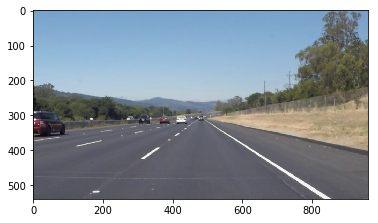

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

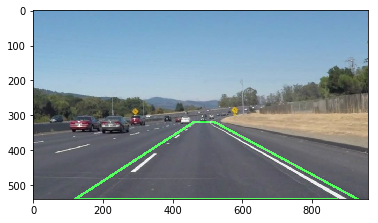

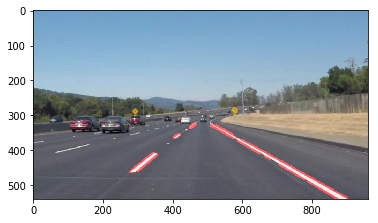

get_coeficients 280 324 465 462
get_coeficients 511 328 898 539
187 895


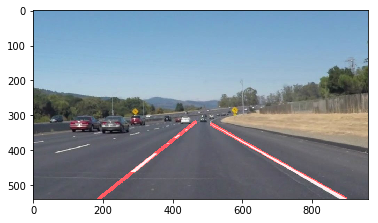

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

def get_coeficients(lines):
    x = []
    y = []
    for x1, y1, x2, y2 in lines:
        x += [x1, x2]
        y += [y1, y2]
    co = np.polyfit(x, y, 1)
    print("get_coeficients", min(x), min(y), max(x), max(y))
    return (co, min(x), max(x))

# Read in and grayscale the image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
imshape = image.shape
vertices = np.array([[(120,imshape[0]),(460, 320), (520, 320), (imshape[1]-30,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# temp code to show the quadrilateral
line_image1 = np.copy(image)*0
cv2.line(line_image1,(120,imshape[0]),(460, 320),(0,255,0),5)
cv2.line(line_image1,(460, 320), (520, 320),(0,255,0),5)
cv2.line(line_image1,(520, 320), (imshape[1]-30,imshape[0]),(0,255,0),5)
cv2.line(line_image1,(imshape[1]-90,imshape[0]),(120,imshape[0]),(0,255,0),5)
lines_edges1 = cv2.addWeighted(line_image1, 0.8, image, 1, 0) 
plt.imshow(lines_edges1)
plt.show()

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 3     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 8 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

left_lines = []
right_lines = []
# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        if (x1 == x2 or y1 == y2):
            continue
        if ((y2-y1)/(x2-x1) < 0):
            left_lines += [[x1, y1, x2, y2]]
        else:
            right_lines += [[x1, y1, x2, y2]]

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(line_image, 0.8, image, 1, 0) 
plt.imshow(lines_edges)
plt.show()

# Draw the extrapolated lines
extraplate_line_image = np.copy(image)*0 # creating a blank to draw lines on
(left_co, min_x_left, max_x_left) = get_coeficients(left_lines)
(right_co, min_x_right, max_x_right) = get_coeficients(right_lines)
f1 = np.poly1d(left_co)
f2 = np.poly1d(right_co)
#print(left_co, min_x_left, int(f1(min_x_left)), max_x_left, int(f1(max_x_left)))
#print(right_co, min_x_right, int(f2(min_x_right)), max_x_right, int(f2(max_x_right)))

m1,b1 = left_co
m2,b2 = right_co
left_x_start = int((imshape[0] - b1)/m1)
right_x_end = int((imshape[0] - b2)/m2)
print(left_x_start, right_x_end)
cv2.line(extraplate_line_image,(left_x_start, int(f1(left_x_start))), (max_x_left, int(f1(max_x_left))),(255,0,0),10)
cv2.line(extraplate_line_image,(min_x_right, int(f2(min_x_right))), (right_x_end, int(f2(right_x_end))),(255,0,0),10)
lines_edges2 = cv2.addWeighted(extraplate_line_image, 0.8, image, 1, 0) 
plt.imshow(lines_edges2)
plt.show()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


def get_coeficients(lines):
    x = []
    y = []
    for x1, y1, x2, y2 in lines:
        x += [x1, x2]
        y += [y1, y2]
    co = np.polyfit(x, y, 1)
    return (co, min(x), max(x))

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)


    # Read in and grayscale the image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    vertices = np.array([[(120,imshape[0]),(450, 320), (520, 320), (imshape[1]-30,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 4     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 8 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    left_lines = []
    right_lines = []
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            if (x1 == x2 or y1 == y2):
                continue
            if (abs((y2-y1)/(x2-x1)) < 0.5 or abs((y2-y1)/(x2-x1)) > 0.8):
                continue
            if ((y2-y1)/(x2-x1) < 0):
                left_lines += [[x1, y1, x2, y2]]
            else:
                right_lines += [[x1, y1, x2, y2]]

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
#     lines_edges = cv2.addWeighted(line_image, 0.8, image, 1, 0) 
#     plt.imshow(lines_edges)
#     plt.show()

    # Draw the extrapolated lines
    extraplate_line_image = np.copy(image)*0 # creating a blank to draw lines on
    (left_co, min_x_left, max_x_left) = get_coeficients(left_lines)
    (right_co, min_x_right, max_x_right) = get_coeficients(right_lines)
    f1 = np.poly1d(left_co)
    f2 = np.poly1d(right_co)
    print("left_co: ", left_co, "right_co", right_co)
    
    m1,b1 = left_co
    m2,b2 = right_co

    left_x_start = int((imshape[0] - b1)/m1)
    right_x_end = int((imshape[0] - b2)/m2)
    cv2.line(extraplate_line_image,(left_x_start, int(f1(left_x_start))), (max_x_left, int(f1(max_x_left))),(255,0,0),10)
    cv2.line(extraplate_line_image,(min_x_right, int(f2(min_x_right))), (right_x_end, int(f2(right_x_end))),(255,0,0),10)
    lines_edges2 = cv2.addWeighted(extraplate_line_image, 0.8, image, 1, 0) 
#     print("left line: ", left_x_start, int(f1(left_x_start)), max_x_left, int(f1(max_x_left)))
#     print("right line: ", min_x_right, int(f2(min_x_right)), right_x_end, int(f2(right_x_end)))

#     plt.imshow(lines_edges2)
#     plt.show()
    return lines_edges2

Let's try the one with the solid white lane on the right first ...

In [23]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

left_co:  [  -0.7143077   648.27970956] right_co [  0.61310305  10.63861927]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 1/222 [00:00<00:26,  8.27it/s]

left_co:  [  -0.7143077   648.27970956] right_co [  0.61310305  10.63861927]
left_co:  [  -0.7301352   653.75183146] right_co [ 0.62294284  5.91399813]
left_co:  [  -0.72056674  651.19640172] right_co [  0.61154419  13.61209271]
left_co:  [  -0.69407091  640.66130658] right_co [ 0.62734568  2.57588166]
left_co:  [  -0.70401901  644.79152643] right_co [ 0.61764234  9.20698235]
left_co:  [  -0.69441116  639.83878158] right_co [  0.59811332  19.4617484 ]
left_co:  [  -0.68541108  635.65985892] right_co [ 0.6166456   9.51843759]
left_co:  [  -0.67564061  632.61844524] right_co [  0.60775776  13.44815703]


  8%|▊         | 18/222 [00:00<00:13, 15.22it/s]

left_co:  [  -0.69627255  640.12005368] right_co [ 0.62012896  5.9070459 ]
left_co:  [  -0.71647562  649.34364511] right_co [  0.60945089  14.64053266]
left_co:  [  -0.70124851  646.61710379] right_co [ 0.62751976  7.8108861 ]
left_co:  [  -0.69710388  644.31397108] right_co [  0.61573682  15.00184247]
left_co:  [  -0.70875232  648.16349955] right_co [ 0.63199875  5.2053016 ]
left_co:  [  -0.71770727  649.41791135] right_co [ 0.62809736  4.54088302]
left_co:  [  -0.70897109  643.64160593] right_co [ 0.64729989 -7.19334248]
left_co:  [  -0.71160192  642.76041979] right_co [ 0.63229343 -0.21220374]
left_co:  [  -0.70815576  641.38091992] right_co [ 0.64597446 -8.56771061]
left_co:  [  -0.71422737  643.24863357] right_co [ 0.6325639  -0.25507303]
left_co:  [  -0.70590263  643.21348779] right_co [ 0.6422944 -5.499032 ]
left_co:  [  -0.7008208   643.57864973] right_co [ 0.638274  -1.3077093]
left_co:  [  -0.68928315  638.59611031] right_co [ 0.62759289  8.19307259]
left_co:  [  -0.69283564 

 16%|█▌        | 36/222 [00:00<00:07, 26.16it/s]

left_co:  [  -0.70478509  643.6013616 ] right_co [ 0.64184399 -2.53443078]
left_co:  [  -0.70629285  646.78502931] right_co [ 0.64618064 -3.28199243]
left_co:  [  -0.70237522  644.91657567] right_co [  0.65933475 -12.79210694]
left_co:  [  -0.6877935   637.48560664] right_co [ 0.64476192 -5.74920498]
left_co:  [  -0.6707989   632.52479339] right_co [ 0.63609854  0.21733855]
left_co:  [  -0.70789004  646.00932752] right_co [ 0.65089429 -9.23856138]
left_co:  [  -0.70049207  641.31791964] right_co [ 0.62728751  3.6902146 ]
left_co:  [  -0.71854981  648.75842105] right_co [ 0.62981262  3.4300645 ]
left_co:  [  -0.6696413   632.14100708] right_co [ 0.6266532   4.87516123]
left_co:  [  -0.71154749  648.03299995] right_co [ 0.63420255  1.28029927]
left_co:  [  -0.6991785   642.55274112] right_co [ 0.63697115  0.0025395 ]
left_co:  [  -0.70616092  646.39308444] right_co [ 0.63316506  2.0149198 ]
left_co:  [  -0.70417484  647.05969113] right_co [ 0.64698516 -4.62070789]
left_co:  [  -0.7051574

 23%|██▎       | 51/222 [00:00<00:04, 38.15it/s]

left_co:  [  -0.75193047  662.67836601] right_co [  0.66853996 -19.69953493]
left_co:  [  -0.69132445  634.60864835] right_co [  0.6575041  -12.12131037]
left_co:  [  -0.72860837  651.93211412] right_co [ 0.63928809 -1.39196924]
left_co:  [  -0.71881455  646.73751407] right_co [  0.6636266  -17.90660218]
left_co:  [  -0.74112909  655.02305584] right_co [ 0.63806376 -1.69582613]
left_co:  [  -0.72500957  649.52972911] right_co [ 0.65018094 -8.75261235]
left_co:  [  -0.71693929  646.99166431] right_co [ 0.64506081 -6.77547746]
left_co:  [  -0.71070022  643.62948407] right_co [  0.65610299 -12.6332221 ]
left_co:  [  -0.72248415  647.86579359] right_co [  0.66120928 -15.27457476]
left_co:  [  -0.70992846  643.2809728 ] right_co [ 0.64263291 -4.23365046]
left_co:  [  -0.70134873  639.44673093] right_co [ 0.64668215 -6.33056699]
left_co:  [  -0.69540915  634.95324027] right_co [ 0.64303678 -3.35066052]
left_co:  [  -0.6876015  634.0440758] right_co [ 0.63992991 -2.01251293]


 29%|██▉       | 65/222 [00:00<00:03, 48.01it/s]

left_co:  [  -0.68099807  629.89877989] right_co [ 0.6487645  -5.89168536]
left_co:  [  -0.6877577   635.05087777] right_co [ 0.64666925 -2.68760234]
left_co:  [  -0.679991    632.40663035] right_co [ 0.64390407 -0.1154986 ]
left_co:  [  -0.69975093  640.45267046] right_co [  0.6606457  -12.12980887]
left_co:  [  -0.68380557  633.39745236] right_co [ 0.64567413 -3.9520444 ]
left_co:  [  -0.70224302  641.97588395] right_co [ 0.64068377 -0.01200481]
left_co:  [  -0.69025327  636.78346001] right_co [  0.65880892 -10.73046752]
left_co:  [  -0.67760875  632.39691774] right_co [ 0.6433401  -0.45115976]
left_co:  [  -0.68528198  635.12562962] right_co [ 0.65044872 -3.45298394]
left_co:  [  -0.71274746  643.36913019] right_co [  0.66028865 -10.26634809]
left_co:  [  -0.65862254  622.64241442] right_co [ 0.65024353 -4.12298353]
left_co:  [  -0.65251511  618.61503646] right_co [ 0.65025118 -5.90768413]
left_co:  [  -0.65479142  619.61004319] right_co [ 0.6456841  -3.94264518]


 36%|███▌      | 79/222 [00:01<00:02, 55.62it/s]

left_co:  [  -0.67947026  629.78603419] right_co [  0.667865   -16.39837327]
left_co:  [  -0.66668717  625.89617249] right_co [  0.65834103 -10.63287025]
left_co:  [  -0.68355339  631.36585449] right_co [ 0.63792412  2.9007309 ]
left_co:  [  -0.67222267  626.66681157] right_co [ 0.65410424 -8.59438267]
left_co:  [  -0.66439349  622.51768213] right_co [ 0.65067741 -4.73086473]
left_co:  [  -0.66974748  626.34500784] right_co [  0.67070086 -15.37726608]
left_co:  [  -0.67109794  626.53606674] right_co [  0.66620142 -14.00497906]
left_co:  [  -0.68514757  631.06441096] right_co [ 0.65870562 -9.26845268]
left_co:  [  -0.69180989  633.28649603] right_co [ 0.65270447 -5.66318394]
left_co:  [  -0.69294796  632.38005064] right_co [  0.66982239 -16.52462593]
left_co:  [  -0.64076421  613.96619822] right_co [  0.68576583 -24.04853219]
left_co:  [  -0.6867351   630.70456639] right_co [  0.68939118 -27.17280729]
left_co:  [  -0.68441687  630.24817179] right_co [  0.66842066 -15.36370955]
left_co: 

 42%|████▏     | 93/222 [00:01<00:02, 59.91it/s]

left_co:  [  -0.6919797   632.90211765] right_co [  0.67067641 -16.72592537]
left_co:  [  -0.68548593  631.69078193] right_co [  0.6649153 -11.3613879]
left_co:  [  -0.68330647  630.75578629] right_co [  0.66606129 -12.93511293]
left_co:  [  -0.68125087  629.81995861] right_co [  0.67194756 -17.58160068]
left_co:  [  -0.68706535  632.49924156] right_co [  0.66450046 -13.24521018]
left_co:  [  -0.68049326  630.33828198] right_co [  0.68083903 -22.34938771]
left_co:  [  -0.68625858  632.32931221] right_co [  0.66888288 -12.99113622]
left_co:  [  -0.66075539  622.07793764] right_co [  0.68928867 -24.73656153]
left_co:  [  -0.63555239  613.35492252] right_co [  0.7081822  -37.36777685]
left_co:  [  -0.65909404  623.15457278] right_co [  0.68561295 -24.33822411]
left_co:  [  -0.65770268  622.70009233] right_co [  0.69132669 -27.41813857]
left_co:  [  -0.65141522  620.37658543] right_co [  0.69597851 -29.19819151]
left_co:  [  -0.66703478  626.18159438] right_co [  0.6854198  -25.31488416]
l

 48%|████▊     | 107/222 [00:01<00:01, 61.48it/s]

 [  -0.6562748   621.31859203] right_co [  0.6712565  -17.50476168]
left_co:  [  -0.66371986  625.1150541 ] right_co [  0.70395386 -38.52605374]
left_co:  [  -0.67368599  627.08314575] right_co [  0.69919236 -35.42987248]
left_co:  [  -0.68387742  631.16459446] right_co [  0.70283782 -39.19925119]
left_co:  [  -0.68357975  631.31431361] right_co [  0.70613691 -40.851595  ]
left_co:  [  -0.67958808  630.35592083] right_co [  0.7208733  -49.67731173]
left_co:  [  -0.64513619  618.87185473] right_co [  0.69660689 -33.38191213]
left_co:  [  -0.66778821  628.60663206] right_co [  0.68392171 -26.07389379]
left_co:  [  -0.67900456  634.15843751] right_co [  0.68620916 -26.69564881]
left_co:  [  -0.63882446  619.68991968] right_co [  0.67564963 -21.28106326]
left_co:  [  -0.66947213  628.95377834] right_co [  0.67614945 -22.91460932]
left_co:  [  -0.67253849  629.26064704] right_co [  0.66717949 -18.74229618]
left_co:  [  -0.68593189  635.15379111] right_co [  0.67215986 -20.0399246 ]
left_co:

 51%|█████▏    | 114/222 [00:01<00:01, 61.90it/s]

left_co:  [  -0.68122594  633.35804929] right_co [  0.67729626 -22.30568172]
left_co:  [  -0.68588231  636.52187846] right_co [  0.67739973 -23.97949848]
left_co:  [  -0.68626214  635.92936771] right_co [  0.65975206 -13.91634711]
left_co:  [  -0.70939004  642.12578486] right_co [  0.67432847 -22.69702938]
left_co:  [  -0.65891605  624.48372711] right_co [  0.68354753 -27.29773752]
left_co:  [  -0.68116988  631.20684321] right_co [  0.66348925 -17.05320147]
left_co:  [  -0.65249484  620.28687293] right_co [  0.66660522 -19.44077779]
left_co:  [  -0.64401287  618.24511722] right_co [ 0.64551328 -6.11522271]
left_co:  [  -0.66736094  627.7901375 ] right_co [  0.65608464 -12.22863836]
left_co:  [  -0.65982193  624.3813774 ] right_co [  0.66438484 -17.97384559]
left_co:  [  -0.65498364  624.19374342] right_co [  0.65324715 -10.46228825]
left_co:  [  -0.66921836  630.62046291] right_co [ 0.64026117 -2.57115566]


 55%|█████▍    | 122/222 [00:01<00:01, 64.02it/s]

left_co:  [  -0.6553521   625.43667184] right_co [ 0.65177835 -8.22100676]
left_co:  [  -0.68345293  637.36171869] right_co [ 0.64451525 -5.34762875]


 58%|█████▊    | 129/222 [00:01<00:01, 64.72it/s]

left_co:  [  -0.66786351  631.20142511] right_co [ 0.6375777  -1.83989434]
left_co:  [  -0.65938087  626.16365404] right_co [  0.65149181 -11.20600566]
left_co:  [  -0.698371    643.31009046] right_co [ 0.63692786 -0.09498473]
left_co:  [  -0.69979818  643.00403633] right_co [ 0.64206123 -4.57493916]
left_co:  [  -0.68171068  636.36596866] right_co [ 0.64413674 -7.35649846]
left_co:  [  -0.69301827  642.74495644] right_co [ 0.62362527  4.83285824]
left_co:  [  -0.69421252  642.85788685] right_co [ 0.62944952  4.35450633]
left_co:  [  -0.69856062  645.68800362] right_co [ 0.62998927  2.52108451]
left_co:  [  -0.69277411  643.35714234] right_co [ 0.63183516  2.10244082]
left_co:  [  -0.69792196  645.03036393] right_co [ 0.61945632  9.16122028]
left_co:  [  -0.68365001  638.49110114] right_co [ 0.62005527  7.5620494 ]


 61%|██████▏   | 136/222 [00:02<00:01, 63.62it/s]

left_co:  [  -0.69703116  640.97365604] right_co [ 0.63194134 -1.55876914]
left_co:  [  -0.70980221  646.95190671] right_co [ 0.6460459  -9.30399401]


 64%|██████▍   | 143/222 [00:02<00:01, 62.66it/s]

left_co:  [  -0.69839812  642.03401834] right_co [  0.65542916 -14.87224561]
left_co:  [  -0.70724875  643.6568496 ] right_co [ 0.61958268  4.51329856]
left_co:  [  -0.70972205  647.9789596 ] right_co [ 0.62422328  4.70399772]
left_co:  [  -0.70530992  646.71998479] right_co [ 0.62784708  2.72258304]
left_co:  [  -0.68292958  638.85472246] right_co [ 0.6380158  -2.52635818]
left_co:  [  -0.71944902  653.47651195] right_co [ 0.62787652  3.7653232 ]
left_co:  [  -0.72924499  658.79352815] right_co [ 0.63142443  0.69783402]
left_co:  [  -0.7291283   658.88355096] right_co [ 0.63638072 -1.56880384]
left_co:  [  -0.70328618  648.47546466] right_co [ 0.6486822 -8.5944701]
left_co:  [  -0.71757265  653.35155032] right_co [ 0.62507925  5.1342492 ]
left_co:  [  -0.7136217   652.36999965] right_co [ 0.62865762  0.55557405]
left_co:  [  -0.71239963  649.73050458] right_co [ 0.61767237  6.1771307 ]
left_co:  [  -0.72232808  654.68806165] right_co [  0.61132276  10.23647482]


 71%|███████   | 157/222 [00:02<00:01, 63.40it/s]

left_co:  [  -0.70421266  648.24374859] right_co [ 0.62855828 -0.69604192]
left_co:  [  -0.70428309  647.69025785] right_co [  0.60977406  11.2292399 ]
left_co:  [  -0.71034924  652.21960771] right_co [ 0.62736743  0.48137543]
left_co:  [  -0.71887955  652.73673079] right_co [ 0.61801246  5.93868023]
left_co:  [  -0.69877052  646.36558412] right_co [ 0.63583493 -3.97074797]
left_co:  [  -0.69553078  644.22565426] right_co [ 0.62967754 -1.85965335]
left_co:  [  -0.70464897  647.73343059] right_co [ 0.61557032  6.29147969]
left_co:  [  -0.73112555  658.15988003] right_co [ 0.62834429 -1.87576787]
left_co:  [  -0.71866542  653.83136782] right_co [ 0.61744667  4.49177188]
left_co:  [  -0.7163216   652.92588163] right_co [ 0.6265231  -1.42397534]
left_co:  [  -0.73073524  658.40514979] right_co [  0.59811235  14.6841683 ]
left_co:  [  -0.73587552  662.70386218] right_co [  0.60340371  12.71790814]
left_co:  [  -0.74507965  667.23129723] right_co [ 0.61185347  6.33612169]
left_co:  [  -0.728

 77%|███████▋  | 171/222 [00:02<00:00, 62.40it/s]


left_co:  [  -0.78155567  682.0658539 ] right_co [  0.59465636  16.75118913]
left_co:  [  -0.76521718  676.9847012 ] right_co [  0.59631516  15.03039319]
left_co:  [  -0.73343942  662.07608615] right_co [  0.58933675  21.66450163]
left_co:  [  -0.72178801  659.30494691] right_co [  0.58316054  25.29133776]
left_co:  [  -0.7376911   665.18697414] right_co [  0.59958968  17.94944857]
left_co:  [  -0.76841175  676.049791  ] right_co [  0.59091179  22.38841062]
left_co:  [  -0.7354648  664.5765712] right_co [  0.58458053  25.42465113]
left_co:  [  -0.75555348  674.058709  ] right_co [  0.59175487  21.66573662]
left_co:  [  -0.76816089  678.59445071] right_co [  0.59494646  18.97910464]
left_co:  [  -0.76107646  674.73394742] right_co [  0.60178953  14.49602199]
left_co:  [  -0.72463768  658.3115942 ] right_co [  0.59501873  19.76595331]
left_co:  [  -0.73301506  664.62945281] right_co [  0.5843548   26.84126477]
left_co:  [  -0.76897248  679.61409423] right_co [  0.57917692  28.29497529]


 83%|████████▎ | 185/222 [00:02<00:00, 64.07it/s]

left_co:  [  -0.76039449  675.73628679] right_co [  0.59820277  17.81545976]
left_co:  [  -0.8  687. ] right_co [  0.58740494  22.8653265 ]
left_co:  [  -0.75356787  671.24009063] right_co [  0.58552801  24.00522453]
left_co:  [  -0.75852035  673.2792451 ] right_co [  0.59819443  15.95509322]
left_co:  [  -0.76475807  675.52736176] right_co [  0.59470854  16.90906207]
left_co:  [  -0.81298259  697.12969507] right_co [  0.5792979   27.21586825]
left_co:  [  -0.79861111  690.50347222] right_co [  0.5810336  24.6171906]
left_co:  [  -0.76529656  675.90083918] right_co [ 0.63443023 -4.84252513]
left_co:  [  -0.76280516  674.88747727] right_co [  0.5950841   15.38249965]
left_co:  [  -0.71661344  653.93040203] right_co [  0.59937154  13.31073053]
left_co:  [  -0.76057757  670.7416051 ] right_co [  0.58708565  22.29083268]
left_co:  [  -0.70860315  652.92599445] right_co [  0.59311127  17.93316833]
left_co:  [  -0.73404646  659.34371831] right_co [  0.57738919  25.47465691]
left_co:  [  -0.7

 90%|████████▉ | 199/222 [00:03<00:00, 64.39it/s]


left_co:  [  -0.75903268  668.52295955] right_co [  0.57028094  27.82897495]
left_co:  [  -0.76540035  671.83048942] right_co [  0.58684175  18.28059534]
left_co:  [  -0.77501723  677.96092895] right_co [  0.56242034  35.9394487 ]
left_co:  [  -0.75603675  673.87483914] right_co [  0.56859552  35.08541478]
left_co:  [  -0.7639282   674.13213207] right_co [  0.58314215  25.45058124]
left_co:  [  -0.74325357  668.87879037] right_co [  0.58820122  24.0077564 ]
left_co:  [  -0.75629768  672.76635394] right_co [  0.5778677   27.55876503]
left_co:  [  -0.70467701  649.78891719] right_co [  0.57719912  28.49687245]
left_co:  [  -0.70936353  651.69534884] right_co [  0.57710737  28.82562427]
left_co:  [  -0.7234238   658.50420447] right_co [  0.58726519  23.46954721]
left_co:  [  -0.73403673  661.26886759] right_co [  0.56897288  33.49499169]
left_co:  [  -0.75266763  670.32286473] right_co [  0.57221853  30.58485242]
left_co:  [  -0.74434834  667.96540201] right_co [  0.57995357  25.94873845

 96%|█████████▌| 213/222 [00:03<00:00, 63.17it/s]

left_co:  [  -0.75991682  671.86363989] right_co [  0.57094773  30.26834368]
left_co:  [  -0.77003517  679.66386132] right_co [  0.58072826  23.94239092]
left_co:  [  -0.752822    669.67629096] right_co [  0.57131884  29.43320501]
left_co:  [  -0.77945433  678.90833308] right_co [  0.57596989  27.67612522]
left_co:  [  -0.76467653  671.46514059] right_co [  0.58048767  22.31069674]
left_co:  [  -0.76804693  673.38103005] right_co [  0.57396434  26.70147416]
left_co:  [  -0.68800481  640.80804262] right_co [  0.56340619  34.54553783]
left_co:  [  -0.74958166  668.44929719] right_co [  0.56369083  33.87645619]
left_co:  [  -0.76019211  676.01150452] right_co [  0.56222743  36.62940854]
left_co:  [  -0.66883117  632.32467532] right_co [  0.54576618  47.6506335 ]
left_co:  [  -0.79676137  690.35020294] right_co [  0.5627912   36.38013531]
left_co:  [  -0.73037199  662.7468599 ] right_co [  0.57546017  30.62628183]
left_co:  [  -0.6949783   646.35089895] right_co [  0.56646628  37.30809737]

100%|█████████▉| 221/222 [00:03<00:00, 64.30it/s]


 [  -0.65887167  630.45191464] right_co [  0.58011336  28.97927399]
left_co:  [  -0.74641643  669.55158671] right_co [  0.55985116  41.02850134]
left_co:  [  -0.78441084  685.45944609] right_co [  0.57864551  29.01121312]
left_co:  [  -0.7629562  674.1535712] right_co [  0.57724367  29.40400383]
left_co:  [  -0.74408711  667.1823798 ] right_co [  0.55925253  39.48170361]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.99 s, sys: 1.26 s, total: 4.25 s
Wall time: 3.87 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

left_co:  [  -0.64475934  618.43357658] right_co [  0.68784854 -29.60211358]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 1/682 [00:00<01:24,  8.08it/s]

left_co:  [  -0.64475934  618.43357658] right_co [  0.68784854 -29.60211358]
left_co:  [  -0.64875353  620.57889197] right_co [  0.67054652 -16.72861359]
left_co:  [  -0.64767243  620.26758142] right_co [  0.67195112 -20.0702727 ]
left_co:  [  -0.63964053  618.81907491] right_co [  0.67387583 -21.18179529]
left_co:  [  -0.64087565  619.97208584] right_co [  0.68780673 -30.34821706]
left_co:  [  -0.66196675  628.54028871] right_co [  0.66353004 -15.85979298]
left_co:  [  -0.65269392  625.55980837] right_co [  0.67527978 -23.61985117]


  2%|▏         | 17/682 [00:00<00:44, 14.83it/s]

left_co:  [  -0.63919666  620.6674444 ] right_co [  0.66377586 -18.77666813]
left_co:  [  -0.63752597  618.8261328 ] right_co [  0.68267828 -30.23025871]
left_co:  [  -0.64532613  623.62914408] right_co [  0.69195517 -37.47923456]
left_co:  [  -0.66511378  629.63888483] right_co [  0.66447334 -19.99887951]
left_co:  [  -0.65983022  627.74278272] right_co [ 0.64607122 -7.93057681]
left_co:  [  -0.64780231  623.57415586] right_co [  0.67602711 -28.14336031]
left_co:  [  -0.66121992  629.10221821] right_co [ 0.6371751  -1.75002526]
left_co:  [  -0.67433388  635.72457493] right_co [ 0.6345088  -1.15945085]
left_co:  [  -0.6736515   636.05552551] right_co [ 0.62495707  5.97050582]
left_co:  [  -0.7022072   645.09460128] right_co [ 0.64321793 -6.13029922]
left_co:  [  -0.670386   633.7594704] right_co [  0.60942128  13.59129985]
left_co:  [  -0.6724096   632.33718804] right_co [  0.70489494 -43.16668623]
left_co:  [  -0.68032566  635.42023491] right_co [ 0.6362396  -3.91491116]
left_co:  [  

  5%|▍         | 33/682 [00:00<00:26, 24.92it/s]

right_co [ 0.63509944 -3.44661759]
left_co:  [  -0.68238554  634.32245868] right_co [ 0.63466428 -3.93059561]
left_co:  [  -0.68677286  636.59199378] right_co [ 0.62774272  1.39569501]
left_co:  [  -0.70839077  645.8075238 ] right_co [ 0.6277251   2.87665122]
left_co:  [  -0.66013116  634.32863305] right_co [  0.61129817  11.40340973]
left_co:  [  -0.69285552  642.45576018] right_co [ 0.61609908  6.20392015]
left_co:  [  -0.69570739  640.87224781] right_co [ 0.62474745 -0.59026248]
left_co:  [  -0.71259185  646.02777869] right_co [ 0.60975412  8.18429694]
left_co:  [  -0.70006091  642.37765142] right_co [  0.64731309 -14.10558355]
left_co:  [  -0.69672136  642.59162255] right_co [ 0.63118524 -4.69465003]
left_co:  [  -0.70870068  646.32438197] right_co [ 0.62801635 -3.81876332]
left_co:  [  -0.70704519  648.79412101] right_co [ 0.62006231  0.25566559]
left_co:  [  -0.70785119  645.82098553] right_co [ 0.62322252 -1.28658093]
left_co:  [  -0.69676151  642.66017379] right_co [ 0.6202111 

  7%|▋         | 48/682 [00:00<00:17, 36.53it/s]

left_co:  [  -0.72713638  649.67594887] right_co [ 0.62287965 -1.10652317]
left_co:  [  -0.72404492  649.97639018] right_co [ 0.60856932  7.52623163]
left_co:  [  -0.74161887  654.44705329] right_co [ 0.60454634  8.98448355]
left_co:  [  -0.75877308  662.17931276] right_co [ 0.61618316  3.09026548]
left_co:  [  -0.73451544  652.37681251] right_co [ 0.60649536  9.31537517]
left_co:  [  -0.74586923  657.51948483] right_co [  0.60397609  10.94558025]
left_co:  [  -0.71577836  647.62925691] right_co [  0.60812306  11.17679283]
left_co:  [  -0.74505797  656.20147032] right_co [ 0.61137103  8.44451242]
left_co:  [  -0.72110004  647.75464926] right_co [ 0.61126905  8.58681545]
left_co:  [  -0.70475709  642.27207975] right_co [ 0.6267382  -0.58129859]
left_co:  [  -0.71620027  647.82640955] right_co [ 0.61702768  4.99009235]
left_co:  [  -0.72732382  647.86589456] right_co [  0.59733705  17.49614986]
left_co:  [  -0.73646455  654.26650234] right_co [  0.58939768  23.88596278]


  8%|▊         | 55/682 [00:00<00:15, 41.73it/s]

left_co:  [  -0.72602715  647.03839145] right_co [  0.59232644  20.03959706]
left_co:  [  -0.73254838  652.17047928] right_co [  0.60044971  15.24714748]
left_co:  [  -0.69843896  642.95635725] right_co [  0.60307019  15.05751815]
left_co:  [  -0.7363762   653.13215609] right_co [  0.60483914  16.14841545]
left_co:  [  -0.73569307  653.12982731] right_co [  0.65171124 -13.32755484]
left_co:  [  -0.74020031  655.02620051] right_co [ 0.62121986  4.444305  ]
left_co:  [  -0.71070925  643.87993821] right_co [  0.66065946 -17.39866831]
left_co:  [  -0.71862387  644.39960422] right_co [ 0.61774231  7.8586426 ]
left_co:  [  -0.73714943  652.59541356] right_co [ 0.63138634 -0.00463091]
left_co:  [  -0.71185136  642.20666143] right_co [ 0.61959231  6.01071884]
left_co:  [  -0.70264396  641.03575214] right_co 

  9%|▉         | 62/682 [00:01<00:13, 44.79it/s]

[ 0.63269166 -0.42710013]
left_co:  [  -0.70498074  640.04456651] right_co [  0.61023997  12.9842743 ]


 10%|▉         | 68/682 [00:01<00:13, 46.65it/s]

left_co:  [  -0.69667653  637.32990227] right_co [  0.60687807  14.59125819]
left_co:  [  -0.71091817  643.42061124] right_co [ 0.62281438  4.09485368]
left_co:  [  -0.71759624  645.91812872] right_co [ 0.61533966  8.94291622]
left_co:  [  -0.70137269  640.66680048] right_co [ 0.62015651  8.08664919]
left_co:  [  -0.70561439  643.07822327] right_co [ 0.61818949  9.2857239 ]
left_co:  [  -0.70094386  641.26403202] right_co [ 0.62076739  7.56746079]
left_co:  [  -0.71867638  647.99512901] right_co [  0.6874326 -32.1659   ]
left_co:  [  -0.69605878  639.31140551] right_co [ 0.62054601  7.11107971]
left_co:  [  -0.70515168  641.83243795] right_co [ 0.62694252  4.47406853]
left_co:  [  -0.69635777  639.29354702] right_co [  0.65289786 -12.19622315]
left_co:  [  -0.7122633   646.32439364] right_co [  0.65742932 -14.66351057]


 12%|█▏        | 80/682 [00:01<00:12, 48.59it/s]

left_co:  [  -0.72986839  653.03900838] right_co [ 0.64581882 -5.94504528]
left_co:  [  -0.71070375  646.79029061] right_co [  0.61864721  10.33120618]
left_co:  [  -0.71296729  646.30175326] right_co [  0.61687397  13.43198206]
left_co:  [  -0.72667383  652.05308394] right_co [ 0.62631923  4.76554131]
left_co:  [  -0.70955683  645.42742162] right_co [ 0.62387638  8.39837652]
left_co:  [  -0.71685681  645.88781638] right_co [ 0.62542904  4.90260313]
left_co:  [  -0.70200947  641.42666238] right_co [  0.69682138 -35.6383084 ]
left_co:  [  -0.70217492  642.17770761] right_co [  0.65892184 -13.28213921]
left_co:  [  -0.70202295  641.96615135] right_co [ 0.65044908 -9.50420955]
left_co:  [  -0.70416542  637.87706341] right_co [  0.65291502 -11.24816097]
left_co: 

 13%|█▎        | 92/682 [00:01<00:12, 48.58it/s]

 [  -0.70740039  640.61608257] right_co [  0.67464454 -22.64353245]
left_co:  [  -0.68384704  632.89037746] right_co [ 0.64648571 -6.63943024]
left_co:  [  -0.69508616  635.99076935] right_co [ 0.640604   -3.12104879]
left_co:  [  -0.68612485  632.96654113] right_co [ 0.64351462 -5.2441276 ]
left_co:  [  -0.68738423  634.23048262] right_co [  0.65803341 -13.30866227]
left_co:  [  -0.70695372  640.55210586] right_co [ 0.63605178  0.61307674]
left_co:  [  -0.67817591  632.15508058] right_co [ 0.63337598  2.8654923 ]
left_co:  [  -0.67503892  631.32321511] right_co [ 0.63211018  3.9940365 ]
left_co:  [  -0.67860008  634.96041139] right_co [ 0.6391132  -0.04184518]
left_co:  [  -0.67750667  634.52420208] right_co [  0.68218749 -23.0156587 ]
left_co:  [  -0.69118857  642.00298259] right_co [ 0.65103105 -4.85707353]


 15%|█▌        | 105/682 [00:01<00:10, 53.90it/s]

left_co:  [  -0.70682636  645.56338241] right_co [  0.69383128 -29.69403788]
left_co:  [  -0.67593219  634.16942094] right_co [ 0.65720058 -8.98149352]
left_co:  [  -0.68389295  635.16643758] right_co [ 0.63994939 -0.46938057]
left_co:  [  -0.69330936  639.82714953] right_co [  0.65522231 -10.32814802]
left_co:  [  -0.70950226  646.35485149] right_co [  0.66585715 -16.96151073]
left_co:  [  -0.6957581   640.34192445] right_co [ 0.64149051 -2.31713957]
left_co:  [  -0.70022348  643.66324093] right_co [ 0.64285081 -2.95996731]
left_co:  [  -0.67498353  632.85383174] right_co [ 0.6346799   3.16703207]
left_co:  [  -0.68715836  636.14833842] right_co [ 0.63747269 -0.47782259]
left_co:  [  -0.70183503  641.89038003] right_co [ 0.62107075  8.83805341]
left_co:  [  -0.7008196  642.1890318] right_co [ 0.63798109 -0.21231427]
left_co:  [  -0.6786829   632.66586696] right_co [ 0.62277668  7.58341568]
left_co:  

 17%|█▋        | 117/682 [00:02<00:10, 53.65it/s]

[  -0.69135871  638.07150596] right_co [  0.66169579 -14.10633139]
left_co:  [  -0.67242663  633.08490204] right_co [  0.66720788 -16.58101614]
left_co:  [  -0.6855163   637.69541488] right_co [  0.66265432 -14.26721961]
left_co:  [  -0.67702083  634.86720232] right_co [ 0.64857422 -5.38015651]
left_co:  [  -0.69025646  638.69561406] right_co [ 0.6346098   2.74483069]
left_co:  [  -0.69365085  641.25821659] right_co [ 0.63813452 -1.27912857]
left_co:  [  -0.67948874  637.26149691] right_co [ 0.6335897   1.84450719]
left_co:  [  -0.69718498  642.88333927] right_co [ 0.63025292  3.68956841]
left_co:  [  -0.69364152  641.49575585] right_co [ 0.63377482  1.62482774]
left_co:  [  -0.69000431  639.13074593] right_co [ 0.63988237 -3.0440555 ]
left_co:  [  -0.69500854  642.66216481] right_co [ 0.63012003  2.53155608]


 19%|█▉        | 129/682 [00:02<00:10, 53.63it/s]

left_co:  [  -0.7148197   650.01147268] right_co [ 0.64764902 -7.54181705]
left_co:  [  -0.70034108  641.86796871] right_co [  0.65409824 -10.80321255]
left_co:  [  -0.67870181  636.6817803 ] right_co [  0.67121052 -20.24659927]
left_co:  [  -0.72856459  653.80160227] right_co [ 0.6412388  -3.05748171]
left_co:  [  -0.68942505  638.97896458] right_co [  0.65224947 -10.84008614]
left_co:  [  -0.69626662  644.5190041 ] right_co [ 0.6417086  -3.84084571]
left_co:  [  -0.69823648  643.27857003] right_co [ 0.63008522  2.51188865]
left_co:  [  -0.68329562  637.25563192] right_co [ 0.64325893 -4.64517141]
left_co:  [  -0.69546499  641.69625744] right_co [ 0.63368295  0.83635672]
left_co:  [  -0.69942526  645.66151281] right_co [ 0.62451262  6.99214605]
left_co:  [  -0.70092882  647.020107  ] right_co [ 0.63293629  2.93705316]
left_co:  [  -0.69282436  644.01294669] right_co [ 0.62529287  5.62024491]


 21%|██        | 142/682 [00:02<00:09, 56.23it/s]

left_co:  [  -0.68735736  640.20882104] right_co [ 0.6348092   0.55624572]
left_co:  [  -0.69655205  643.68609822] right_co [ 0.65136705 -8.82574399]
left_co:  [  -0.68392818  638.80987512] right_co [ 0.64338832 -4.12262658]
left_co:  [  -0.69883469  645.62738306] right_co [ 0.64153386 -2.09475092]
left_co:  [  -0.69798302  644.34436715] right_co [  0.61809693  10.29503106]
left_co:  [  -0.68615255  641.27360333] right_co [ 0.6234006   8.58003435]
left_co:  [  -0.70365812  649.42820062] right_co [ 0.63921228 -0.04961585]
left_co:  [  -0.69758624  645.26597632] right_co [ 0.62059364  8.91333376]
left_co:  [  -0.69495047  642.95997896] right_co [  0.6135361   14.64873387]
left_co:  [  -0.70351753  648.01170615] right_co [ 0.62652752  6.74691273]
left_co:  [  -0.70240102  647.03575628] right_co [  0.61403603  13.31731146]
left_co:  [  -0.70340718  646.49234725] right_co [ 0.63501815  2.2795558 ]
left_co: 

 23%|██▎       | 155/682 [00:02<00:09, 57.23it/s]

 [  -0.68388733  639.59043831] right_co [  0.61022041  15.98380943]
left_co:  [  -0.69040646  641.30787195] right_co [  0.61336201  14.15348135]
left_co:  [  -0.69348422  642.1263476 ] right_co [ 0.64574764 -4.26525282]
left_co:  [  -0.69033956  640.6062475 ] right_co [  0.60684338  17.57528693]
left_co:  [  -0.693671   643.8944922] right_co [  0.60329879  19.98766655]
left_co:  [  -0.68466043  638.64854306] right_co [  0.61721828  12.27535823]
left_co:  [  -0.68277433  637.64380102] right_co [ 0.62494147  7.36849435]
left_co:  [  -0.69564518  643.38814252] right_co [  0.61044667  15.19858163]
left_co:  [  -0.68417763  641.04723425] right_co [  0.60731196  17.64017597]
left_co:  [  -0.67867275  639.81475887] right_co [  0.60832335  17.72330129]
left_co:  [  -0.70701505  649.62036424] right_co [  0.61800408  10.1642143 ]
left_co:  [  -0.70871631  652.57192309] right_co [  0.61113907  17.0097541 ]
left_co:  [  -0.68782011  644.83121966] right_co [  0.60964268  18.42088693]


 24%|██▎       | 161/682 [00:02<00:09, 54.40it/s]

left_co:  [  -0.69372426  646.75630107] right_co [  0.59990499  23.72256489]
left_co:  [  -0.68548897  643.02108242] right_co [  0.58021694  35.40951786]
left_co:  [  -0.68310464  643.82938365] right_co [  0.58245753  33.9636888 ]
left_co:  [  -0.70297884  652.33344186] right_co [  0.58588362  32.55044848]
left_co:  [  -0.72010686  658.92987613] right_co [  0.57383525  39.58051867]
left_co:  [  -0.70273162  651.80919228] right_co [  0.61346952  15.90028328]
left_co:  [  -0.70854567  654.13858027] right_co [  0.58658599  29.8457518 ]
left_co:  [  -0.69387511  649.25954254] right_co [  0.59361234  26.24789841]
left_co:  [  -0.69728986  651.58171669] right_co [  0.58169787  32.39902293]
left_co:  [  -0.70765753  654.57608802] right_co [  0.58432212  29.5592462 ]
left_co:  [  -0.68347192  647.40881136] right_co [  0.58160168  31.28298939]
left_co:  [  -0.73779586  664.66487632] right_co [  0.59649302  22.79901586]


 25%|██▌       | 173/682 [00:03<00:09, 54.39it/s]

left_co:  [  -0.73172515  663.95626426] right_co [  0.6053545   16.79748571]
left_co:  [  -0.68178317  649.46198326] right_co [  0.59156058  24.43462013]
left_co:  [  -0.72014986  659.64293859] right_co [  0.5927186   22.89231503]
left_co:  [  -0.71226625  657.24143519] right_co [  0.5686402   36.29659316]
left_co:  [  -0.73418765  664.28803117] right_co [  0.58929275  25.06155828]
left_co:  [  -0.72991064  663.76899394] right_co [  0.59451916  21.19196481]
left_co:  [  -0.75607169  674.44562338] right_co [  0.57142432  34.36571329]
left_co:  [  -0.74416244  670.72394444] right_co [  0.56166425  40.21494158]
left_co:  [  -0.75761482  673.53505351] right_co [  0.57249905  34.08133091]
left_co:  [  -0.74670642  669.69473491] right_co [  0.56579934  37.26643091]
left_co:  [  -0.75796822  675.91775648] right_co [  0.56877043  36.77596206]


 27%|██▋       | 185/682 [00:03<00:10, 48.81it/s]

left_co:  [  -0.75610925  675.37011387] right_co [  0.57238571  35.6220127 ]
left_co:  [  -0.76726989  679.34514702] right_co [  0.56832824  37.39271093]
left_co:  [  -0.7464438   669.12591671] right_co [  0.56673779  38.64729807]
left_co:  [  -0.75918751  678.12199468] right_co [  0.54704925  48.34688038]
left_co:  [  -0.73338649  665.92359039] right_co [  0.5535515  44.6442548]
left_co:  [  -0.74927068  670.895961  ] right_co [  0.56110684  41.8191562 ]
left_co:  [  -0.72992808  666.60980472] right_co [  0.560134    42.55731488]
left_co:  [  -0.73815234  671.03170048] right_co [  0.55979397  42.69308156]
left_co:  [  -0.74072497  669.14942965] right_co [  0.55795385  44.71844132]
left_co: 

 29%|██▊       | 195/682 [00:03<00:10, 47.92it/s]

 [  -0.76371523  676.45230109] right_co [  0.54571256  51.44132583]
left_co:  [  -0.74493671  672.55031754] right_co [  0.56244186  42.04265283]
left_co:  [  -0.77362718  680.95258139] right_co [  0.56105457  43.01865654]
left_co:  [  -0.77769955  681.63577554] right_co [  0.54991418  50.22562675]
left_co:  [  -0.78991752  686.86693634] right_co [  0.55477113  46.62118663]
left_co:  [  -0.77715177  682.52758077] right_co [  0.55522013  47.270994  ]
left_co:  [  -0.77550232  680.72945061] right_co [  0.56418615  42.5042423 ]
left_co:  [  -0.76761719  677.15782158] right_co [  0.56488332  40.13716562]
left_co:  [  -0.76921204  679.6843582 ] right_co [  0.57124089  36.90221427]
left_co:  [  -0.77568693  677.99780897] right_co [  0.55579773  46.24358229]
left_co: 

 30%|███       | 207/682 [00:03<00:09, 51.35it/s]

 [  -0.74151395  667.30896859] right_co [  0.55754374  45.77713181]
left_co:  [  -0.76409817  675.24493455] right_co [  0.57626354  34.66803476]
left_co:  [  -0.72626094  663.07816599] right_co [  0.55953973  46.21425701]
left_co:  [  -0.74598314  665.873618  ] right_co [  0.55793248  46.37255349]
left_co:  [  -0.73268208  661.29485714] right_co [  0.56663526  41.61038648]
left_co:  [  -0.77255775  676.39881699] right_co [  0.57073244  40.50546099]
left_co:  [  -0.78408319  680.20471221] right_co [  0.57091357  40.86290008]
left_co:  [  -0.75756453  669.62588195] right_co [  0.57012521  41.76697792]
left_co:  [  -0.75023499  667.56548986] right_co [  0.57518689  39.96572493]
left_co:  [  -0.7569853  670.9108634] right_co [  0.59291901  28.00668591]
left_co:  [  -0.76094689  673.23564236] right_co [  0.56999795  41.81368052]
left_co:  [  -0.7304682   660.29680492] right_co [  0.56599867  43.95409104]
left_co:  [  -0.74823994  666.47017651] right_co [  0.58234847  33.74502309]


 32%|███▏      | 220/682 [00:04<00:09, 51.20it/s]

left_co:  [  -0.72548242  660.4575556 ] right_co [  0.56624746  44.80803238]
left_co:  [  -0.71937873  657.86800161] right_co [  0.57179719  42.67897109]
left_co:  [  -0.72122211  658.45302744] right_co [  0.57342814  40.50805353]
left_co:  [  -0.72401376  659.92814326] right_co [  0.57882753  38.23401963]
left_co:  [  -0.7118055   652.94127165] right_co [  0.58303359  36.40432356]
left_co:  [  -0.73314993  659.9281879 ] right_co [  0.58219551  34.98882987]
left_co:  [  -0.73100733  659.24871168] right_co [  0.58278184  35.49121508]
left_co:  [  -0.71425696  653.92692291] right_co [  0.59203332  30.15835822]
left_co:  [  -0.72560256  655.29557463] right_co [  0.57901674  37.52862352]
left_co:  [  -0.70171811  647.59378298] right_co [  0.58921925  33.08078613]


 34%|███▍      | 232/682 [00:04<00:08, 53.71it/s]

left_co:  [  -0.69983105  647.06592967] right_co [  0.61153719  18.75100395]
left_co:  [  -0.72382302  656.04226599] right_co [  0.60083509  23.66332449]
left_co:  [  -0.7246026   656.23173311] right_co [  0.5800797   36.64965732]
left_co:  [  -0.71371142  653.58953318] right_co [  0.58135232  35.12005946]
left_co:  [  -0.72348963  657.53172194] right_co [  0.59402291  27.47211658]
left_co:  [  -0.74546708  663.24335749] right_co [  0.5808117   36.75394485]
left_co:  [  -0.71611521  651.96887666] right_co [  0.59920466  24.79886164]
left_co:  [  -0.71718525  655.43326375] right_co [  0.59099359  28.33059714]
left_co:  [  -0.7282142   657.19404267] right_co [  0.59091863  28.20926022]
left_co:  [  -0.72353242  654.47976517] right_co [  0.60764459  17.94765384]
left_co:  [  -0.73399979  657.06654835] right_co [  0.59587048  25.99802896]
left_co:  [  -0.72867044  656.20494089] right_co [  0.59374577  26.27386674]


 36%|███▌      | 245/682 [00:04<00:07, 57.51it/s]

left_co:  [  -0.70982342  648.07612614] right_co [  0.60839211  18.17652708]
left_co:  [  -0.70687282  649.50771237] right_co [  0.58866435  30.03399193]
left_co:  [  -0.69960342  648.6013144 ] right_co [  0.6107322   17.67591081]
left_co:  [  -0.70511701  644.92105373] right_co [  0.6113733   16.46020718]
left_co:  [  -0.70499835  647.73352566] right_co [  0.58360071  31.85918185]
left_co:  [  -0.69055581  642.4444732 ] right_co [  0.58715134  30.27388383]
left_co:  [  -0.70609025  647.94246977] right_co [  0.59418347  24.5828807 ]
left_co:  [  -0.70790346  647.02782633] right_co [  0.59953331  22.70157428]
left_co:  [  -0.70250024  646.77103481] right_co [  0.58919382  27.98999542]
left_co:  [  -0.69337368  642.65400798] right_co [  0.58978346  29.28070987]
left_co:  [  -0.7030223   643.81864857] right_co [  0.59740843  24.71953772]
left_co:  [  -0.69941908  646.86296533] right_co [  0.56168917  45.3155282 ]
left_co:  [  -0.69238391  644.45146439] right_co [  0.60704411  19.08110186]

 37%|███▋      | 252/682 [00:04<00:07, 59.43it/s]

left_co:  [  -0.71316596  652.62067099] right_co [  0.5776768  37.1424976]
left_co:  [  -0.72811853  657.18818206] right_co [  0.59839114  26.23551455]
left_co:  [  -0.70931912  649.22951125] right_co [  0.58169491  36.08140803]
left_co:  [  -0.69142258  642.97724533] right_co [  0.55743146  52.55411255]
left_co:  [  -0.69507403  644.87182389] right_co [  0.59168726  30.15798005]
left_co:  [  -0.70722997  646.1461262 ] right_co [  0.60937109  18.57353872]
left_co:  [  -0.70774362  648.55601595] right_co [  0.59113338  30.88938089]
left_co:  [  -0.70034976  647.80312701] right_co [  0.59826276  27.02982199]
left_co:  [  -0.70102371  647.33488658] right_co [  0.60356749  24.34691092]
left_co:  [  -0.69681244  646.51379374] right_co [  0.60267893  23.90154003]
left_co:  [  -0.71224771  649.86503777] right_co [  0.59978372  24.37450536]
left_co:  [  -0.73370401  658.98348469] right_co [  0.59899918  26.37640898]
left_co:  [  -0.72842734  655.50778187] right_co [  0.56924021  42.20505796]
l

 39%|███▉      | 266/682 [00:04<00:06, 60.52it/s]

left_co:  [  -0.73948012  659.56479769] right_co [  0.59409392  28.4655126 ]
left_co:  [  -0.72094529  652.85700341] right_co [  0.5943129   27.90190125]
left_co:  [  -0.71833215  652.53006155] right_co [  0.61915672  13.72796075]
left_co:  [  -0.70570173  648.69074753] right_co [  0.59651229  26.66814281]
left_co:  [  -0.71356877  652.24592488] right_co [  0.58803093  31.36014954]
left_co:  [  -0.72918346  655.93731513] right_co [  0.60632546  20.69220399]
left_co:  [  -0.71754892  653.02519018] right_co [  0.60070447  22.91677809]
left_co:  [  -0.70429792  649.5659866 ] right_co [  0.59341394  29.64968972]
left_co:  [  -0.71152722  650.38223013] right_co [  0.59437281  27.06224344]
left_co:  [  -0.69600412  646.25361382] right_co [  0.60419056  19.65948044]
left_co:  [  -0.70906068  650.2727651 ] right_co [  0.57762435  34.61383319]
left_co:  [  -0.69513258  644.9388547 ] right_co [  0.55410303  48.87977247]
left_co:  [  -0.70011832  650.69951384] right_co [  0.54563335  53.90432134]

 41%|████      | 280/682 [00:05<00:06, 62.14it/s]

 [  -0.71284197  653.65621502] right_co [  0.56999009  40.07025369]
left_co:  [  -0.71197345  652.93625844] right_co [  0.55419672  48.94145141]
left_co:  [  -0.71423242  655.63953326] right_co [  0.56169745  44.84623473]
left_co:  [  -0.70092357  649.92629178] right_co [  0.55325541  49.49984012]
left_co:  [  -0.72203863  658.04458705] right_co [  0.56549469  41.71017267]
left_co:  [  -0.72133276  656.24279558] right_co [  0.56196318  45.77507237]
left_co:  [  -0.72610589  657.8329191 ] right_co [  0.59580169  24.00818248]
left_co:  [  -0.7225224   657.67113226] right_co [  0.58038195  35.77204879]
left_co:  [  -0.70209188  650.45351109] right_co [  0.57607268  38.79362202]
left_co:  [  -0.72670476  660.26911931] right_co [  0.5810458   36.79041306]
left_co:  [  -0.7212366   657.87580997] right_co [  0.5604873   49.08081936]
left_co:  [  -0.71862114  656.01762109] right_co [  0.56574256  46.44074739]
left_co:  [  -0.73361823  662.46209719] right_co [  0.55557045  50.31259295]


 43%|████▎     | 294/682 [00:05<00:06, 62.83it/s]

left_co:  [  -0.70319306  649.29247982] right_co [  0.56195818  47.67593226]
left_co:  [  -0.71563598  653.47763514] right_co [  0.56398806  46.69248194]
left_co:  [  -0.7122925   654.66462257] right_co [  0.58105981  38.35262094]
left_co:  [  -0.70509144  653.086196  ] right_co [  0.56880287  47.21883077]
left_co:  [  -0.6994711   651.21972662] right_co [  0.57540146  43.96357869]
left_co:  [  -0.71061928  655.23863532] right_co [  0.58664669  36.06604227]
left_co:  [  -0.7182096   656.53761727] right_co [  0.56895716  49.37101582]
left_co:  [  -0.70963108  653.77151194] right_co [  0.57847514  40.35259965]
left_co:  [  -0.707413    651.93232214] right_co [  0.58719226  35.63102215]
left_co:  [  -0.73633368  662.34287026] right_co [  0.60247099  25.75973587]
left_co:  [  -0.7106999   653.10020645] right_co [  0.61767081  16.5915528 ]
left_co:  [  -0.7198285   656.49023325] right_co [  0.61139161  18.10725438]
left_co:  [  -0.71797092  656.1763815 ] right_co [  0.61907188  15.48551712]

 45%|████▌     | 308/682 [00:05<00:06, 59.84it/s]

left_co:  [  -0.70770277  654.11207513] right_co [  0.59966123  27.18298066]
left_co:  [  -0.72366797  660.37039056] right_co [  0.61799439  16.54730151]
left_co:  [  -0.75099029  669.43903614] right_co [  0.60732767  21.90973356]
left_co:  [  -0.71783205  657.14236895] right_co [  0.59651766  28.06627449]
left_co:  [  -0.70857149  653.16369171] right_co [  0.59845739  26.61979674]
left_co:  [  -0.73056361  659.06269126] right_co [  0.61843052  12.89813031]
left_co:  [  -0.73719201  662.07737353] right_co [  0.61378373  17.05790446]
left_co:  [  -0.73973642  660.43001981] right_co [  0.6159045   15.72390785]
left_co:  [  -0.72491937  652.87014955] right_co [  0.61886227  12.36487876]
left_co:  [  -0.73910995  659.91552476] right_co [  0.61217122  17.04339902]
left_co:  [  -0.70753649  647.50866781] right_co [  0.5963883   25.56650277]
left_co:  [  -0.73162811  656.17500675] right_co [  0.61405462  13.6936103 ]


 47%|████▋     | 321/682 [00:05<00:06, 59.04it/s]

left_co:  [  -0.71099271  648.23610002] right_co [  0.6008447   21.97776344]
left_co:  [  -0.71209569  648.05324058] right_co [  0.60321122  21.13553385]
left_co:  [  -0.73112531  655.78608017] right_co [  0.59959777  23.46190441]
left_co:  [  -0.69279252  643.33724635] right_co [  0.60718737  18.71268159]
left_co:  [  -0.71394667  650.19932287] right_co [  0.6033247   21.68352513]
left_co:  [  -0.70739416  647.20029122] right_co [  0.6125606   14.43910752]
left_co:  [  -0.71376746  649.83558538] right_co [  0.59528855  26.41283343]
left_co:  [  -0.73133553  656.24091683] right_co [  0.59084065  29.95946646]
left_co:  [  -0.69204969  643.30214099] right_co [  0.58335876  34.5474468 ]
left_co:  [  -0.7153084   650.23367139] right_co [  0.59510419  25.12278901]
left_co:  [  -0.7055984   646.56547314] right_co [  0.59438848  26.21878226]
left_co:  [  -0.72530277  653.27268891] right_co [  0.57453621  38.00428266]
left_co: 

 49%|████▉     | 334/682 [00:05<00:05, 59.34it/s]

 [  -0.70200102  645.19862268] right_co [  0.58977434  28.57662049]
left_co:  [  -0.73222297  655.76414635] right_co [  0.58969793  29.79976774]
left_co:  [  -0.68559007  640.36201126] right_co [  0.5971629   25.99103216]
left_co:  [  -0.70265848  646.15322037] right_co [  0.59838601  25.88420495]
left_co:  [  -0.71440489  652.88490333] right_co [  0.60760618  21.27050054]
left_co:  [  -0.69997185  647.55204904] right_co [  0.59214279  30.84568627]
left_co:  [  -0.68301241  640.20244356] right_co [  0.5960165   28.86240794]
left_co:  [  -0.7113552   646.99569404] right_co [  0.58692218  33.86800612]
left_co:  [  -0.71470531  647.7471327 ] right_co [  0.60299262  22.62371425]
left_co:  [  -0.69181684  639.32407446] right_co [  0.58201454  33.70971646]
left_co:  [  -0.69187102  638.76862876] right_co [  0.55371916  51.01850413]
left_co:  [  -0.69632373  642.01576184] right_co [  0.56630793  44.80551239]
left_co:  [  -0.70041193  643.44183272] right_co [  0.60458975  24.01204382]
left_co:

 51%|█████     | 348/682 [00:06<00:05, 62.44it/s]

left_co:  [  -0.67532887  633.93333337] right_co [  0.60026001  26.75782692]
left_co:  [  -0.66796766  632.38958668] right_co [  0.61637094  16.27555536]
left_co:  [  -0.67372877  633.48515599] right_co [  0.61215782  20.29286147]
left_co:  [  -0.66417857  632.04644395] right_co [  0.61801733  14.35276472]
left_co:  [  -0.67960282  635.98689299] right_co [  0.60013167  26.54976505]
left_co:  [  -0.67085344  632.09418739] right_co [  0.60560001  23.05177093]
left_co:  [  -0.68641934  639.69369959] right_co [  0.60628002  23.1526536 ]
left_co:  [  -0.67038013  631.03775052] right_co [  0.57909813  36.48964496]
left_co:  [  -0.67019208  634.75544184] right_co [  0.60329451  24.13907579]
left_co:  [  -0.66628268  634.17322204] right_co [  0.60220167  25.50482316]
left_co:  [  -0.66805919  632.44019128] right_co [  0.62597615  10.68658338]
left_co:  [  -0.68269161  639.15819115] right_co [  0.59900187  27.14935395]
left_co:  [  -0.67635295  636.65412023] right_co [  0.59657798  27.72819126]

 53%|█████▎    | 362/682 [00:06<00:04, 64.00it/s]

left_co:  [  -0.68431173  640.92840684] right_co [  0.61054947  20.59717366]
left_co:  [  -0.69401345  644.29152522] right_co [  0.61086234  19.73319232]
left_co:  [  -0.67861864  640.43340076] right_co [  0.60820538  22.64452221]
left_co:  [  -0.68426013  640.28328936] right_co [  0.60728436  22.44942093]
left_co:  [  -0.6829855   638.76507876] right_co [  0.61318687  18.05167198]
left_co:  [  -0.68762941  640.4415567 ] right_co [  0.61284421  18.52190155]
left_co:  [  -0.70286149  644.73875445] right_co [  0.55176899  53.6682102 ]
left_co:  [  -0.65649855  632.07750507] right_co [  0.55632558  50.92881805]
left_co:  [  -0.6656972  630.8489124] right_co [  0.5855174   34.68119783]
left_co:  [  -0.69086072  640.87850077] right_co [  0.62025153  14.05303291]
left_co:  [  -0.70293952  642.60330762] right_co [  0.62117507  14.79212872]
left_co:  [  -0.68113587  635.47474164] right_co [  0.60197371  25.55042391]
left_co:  [  -0.67293725  633.43922434] right_co [  0.58914122  33.82778476]


 55%|█████▌    | 376/682 [00:06<00:04, 65.27it/s]

left_co:  [  -0.69003212  640.63263604] right_co [  0.59439758  29.87177617]
left_co:  [  -0.71126331  650.13914477] right_co [  0.60196897  26.99923277]
left_co:  [  -0.710736    648.29810041] right_co [  0.6127871   18.12720376]
left_co:  [  -0.70296583  644.86978698] right_co [  0.60123184  27.38931543]
left_co:  [  -0.70963621  645.27812238] right_co [  0.60022806  28.3963245 ]
left_co:  [  -0.6996461   643.02403122] right_co [  0.57123183  43.58500152]
left_co:  [  -0.70355071  647.14997318] right_co [  0.61321818  20.58557538]
left_co:  [  -0.69644496  642.25137368] right_co [  0.57770564  39.34737614]
left_co:  [  -0.70663682  644.23805861] right_co [  0.58422343  34.20546278]
left_co:  [  -0.70222065  644.03701506] right_co [  0.61970895  16.73311433]
left_co:  [  -0.70846067  645.7068085 ] right_co [  0.5897524   32.98723505]
left_co:  [  -0.72599984  651.16175305] right_co [  0.59855773  28.38596843]
left_co:  [  -0.73032717  654.21448701] right_co [  0.59750849  30.0704465 ]

 57%|█████▋    | 390/682 [00:06<00:04, 65.52it/s]

left_co:  [  -0.70852065  643.06694969] right_co [  0.60233671  26.60076283]
left_co:  [  -0.68881098  634.87855697] right_co [  0.60526805  24.50582972]
left_co:  [  -0.71286247  646.05886083] right_co [  0.59901103  27.69080142]
left_co:  [  -0.68599952  633.87272704] right_co [  0.58976489  33.14274009]
left_co:  [  -0.68682076  636.31358339] right_co [  0.5791569   38.91099722]
left_co:  [  -0.70910204  644.02324174] right_co [  0.59655256  29.4612835 ]
left_co:  [  -0.70950799  644.96176089] right_co [  0.59811037  29.22542033]
left_co:  [  -0.69516541  640.74414598] right_co [  0.57948997  39.290944  ]
left_co:  [  -0.70500487  642.31273223] right_co [  0.60156328  27.40448673]
left_co:  [  -0.70299363  642.64165336] right_co [  0.59554707  30.36725491]
left_co:  [  -0.68680085  634.94043861] right_co [  0.60902105  22.31613193]
left_co:  [  -0.68574846  634.58588455] right_co [  0.60518751  24.22881199]
left_co:  [  -0.69096196  636.47702255] right_co [  0.61378979  19.69297391]

 59%|█████▉    | 404/682 [00:06<00:04, 65.94it/s]

left_co:  [  -0.69481383  640.56105907] right_co [  0.62082668  16.61019123]
left_co:  [  -0.67677743  632.68738602] right_co [  0.62109875  15.76958507]
left_co:  [  -0.68925404  636.45209612] right_co [  0.59494547  29.30458376]
left_co:  [  -0.69086714  638.67692305] right_co [  0.61476179  20.09950924]
left_co:  [  -0.67956245  634.63794586] right_co [  0.60763235  24.27996173]
left_co:  [  -0.70976311  644.39793822] right_co [  0.61906525  16.9099202 ]
left_co:  [  -0.66644751  628.66418972] right_co [  0.61979791  16.88147143]
left_co:  [  -0.68578365  635.62202623] right_co [  0.62039935  17.32265253]
left_co:  [  -0.66489     626.72520365] right_co [  0.63086752  11.37416181]
left_co:  [  -0.69037193  638.14612251] right_co [ 0.6327916   9.59726205]
left_co:  [  -0.68014053  634.60078301] right_co [ 0.64530206  2.23419577]
left_co:  [  -0.66435263  627.9258973 ] right_co [ 0.64426187  3.60451798]
left_co:  [  -0.66853571  630.47545313] right_co [ 0.63898028  8.58189251]
left_co

 61%|██████▏   | 418/682 [00:07<00:03, 66.60it/s]

left_co:  [  -0.69134641  638.29990227] right_co [  0.62554537  14.05774381]
left_co:  [  -0.67223632  632.982493  ] right_co [  0.62101991  16.45640885]
left_co:  [  -0.69507423  640.03237177] right_co [ 0.64925346  0.01620299]
left_co:  [  -0.67892722  634.21995753] right_co [  0.61344672  20.0738496 ]
left_co:  [  -0.69309915  640.06247589] right_co [  0.62451364  14.33732173]
left_co:  [  -0.67294737  633.1256864 ] right_co [ 0.64567539  3.1061952 ]
left_co:  [  -0.70132276  642.50580327] right_co [ 0.63364956  8.66671044]
left_co:  [  -0.67701623  630.99946663] right_co [ 0.64434165  2.00653142]
left_co:  [  -0.67764563  630.99778115] right_co [ 0.65018234 -3.44087068]
left_co:  [  -0.66993182  628.82454426] right_co [ 0.62952665  7.76116304]
left_co:  [  -0.671784   630.1444222] right_co [ 0.64053124  1.7805301 ]
left_co:  [  -0.6818514   635.46590868] right_co [  0.62241391  11.52988102]
left_co:  [  -0.67805749  635.5088342 ] right_co [  0.60628898  22.41869617]
left_co:  [  -0

 62%|██████▏   | 425/682 [00:07<00:03, 64.59it/s]

left_co:  [  -0.6705436   633.64095133] right_co [  0.6192633  15.765558 ]
left_co:  [  -0.67458409  633.69160415] right_co [ 0.63500571  7.20049165]
left_co:  [  -0.67829881  634.56267638] right_co [ 0.63893393  4.17669099]
left_co:  [  -0.68442633  638.64165025] right_co [ 0.6331919   6.49747964]
left_co:  [  -0.67722888  635.94137812] right_co [ 0.63312479  5.65127911]
left_co:  [  -0.67558891  635.02266346] right_co [ 0.63765957  3.61880167]
left_co:  [  -0.67588516  633.21167669] right_co [ 0.62929291  8.87666887]
left_co:  [  -0.68495846  638.92430016] right_co [ 0.63217602  5.14622037]
left_co:  [  -0.7001724   643.38095925] right_co [  0.62249126  12.22308157]
left_co:  [  -0.6826054   637.31150445] right_co [ 0.64093945  2.3875741 ]
left_co:  [  -0.67461616  632.71188379] right_co [ 0.65341076 -5.03189208]
left_co:  [  -0.6941905   641.31146702] right_co [  0.62307723  11.55587071]
left_co:  [  -0.67765552  633.69703379] right_co [ 0.64899316 -3.66815778]
left_co:  [  -0.70607

 65%|██████▌   | 446/682 [00:07<00:03, 65.24it/s]

 [  0.61967378  13.34033915]
left_co:  [  -0.68649624  637.07341646] right_co [  0.62568821  10.36212111]
left_co:  [  -0.68123623  635.9051716 ] right_co [ 0.63208688  6.10186526]
left_co:  [  -0.67041172  631.10404202] right_co [ 0.63058774  7.2125856 ]
left_co:  [  -0.68670302  636.99729369] right_co [ 0.62894485  9.14354714]
left_co:  [  -0.68191102  635.478582  ] right_co [  0.62001073  13.74324625]
left_co:  [  -0.68983787  637.81551637] right_co [  0.62475111  10.82414768]
left_co:  [  -0.70148932  643.27329003] right_co [  0.62381702  10.6205633 ]
left_co:  [  -0.66903025  627.37197911] right_co [ 0.63213568  6.17387081]
left_co:  [  -0.67193046  628.66907907] right_co [ 0.65235587 -5.78158876]
left_co:  [  -0.67399152  628.84239827] right_co [  0.60369836  21.27766266]
left_co:  [  -0.67204765  627.67868651] right_co [  0.61117479  17.87707736]
left_co:  [  -0.67109365  629.31298983] right_co [  0.61746137  14.00942387]
left_co:  [  -0.67195057  629.39024981] right_co [  0.623

 67%|██████▋   | 460/682 [00:07<00:03, 65.12it/s]

left_co:  [  -0.67293809  631.0580852 ] right_co [ 0.63004328  8.70292119]
left_co:  [  -0.67972183  632.24908959] right_co [ 0.62678914  9.78603292]
left_co:  [  -0.68740469  635.38739145] right_co [ 0.64298006  0.13841464]
left_co:  [  -0.68017035  631.30021285] right_co [ 0.63903215  1.92495406]
left_co:  [  -0.6870499   633.89078608] right_co [ 0.62993042  7.34452685]
left_co:  [  -0.67687949  630.79331556] right_co [ 0.64112511  0.04041486]
left_co:  [  -0.68943035  634.0066273 ] right_co [ 0.63367008  3.41745567]
left_co:  [  -0.658158    621.99324061] right_co [ 0.62776323  5.28982587]
left_co:  [  -0.66598443  624.14586419] right_co [  0.61828059  10.6422903 ]
left_co:  [  -0.64932455  618.98253367] right_co [  0.61323613  13.99565889]
left_co:  [  -0.67275882  627.93263266] right_co [ 0.64205135 -0.33553598]
left_co:  [  -0.6513819   622.44348369] right_co [ 0.64186093  0.80455004]
left_co:  [  -0.66291109  626.66263878] right_co [  0.61898338  15.3183007 ]
left_co:  [  -0.654

 68%|██████▊   | 467/682 [00:07<00:03, 63.96it/s]

left_co:  [  -0.66814682  628.46082126] right_co [ 0.63247494  4.6147616 ]
left_co:  [  -0.66790319  627.11296858] right_co [ 0.63449976  2.69687064]
left_co:  [  -0.6561522   625.03951707] right_co [ 0.62594238  9.59853693]
left_co:  [  -0.65831866  626.08227583] right_co [  0.61403032  17.02957548]
left_co:  [  -0.66656832  629.28541324] right_co [  0.62078662  12.92067238]
left_co:  [  -0.6784146   634.87261192] right_co [  0.62105687  12.49092793]
left_co:  [  -0.67535603  632.43356405] right_co [  0.59189468  28.19209031]
left_co:  [  -0.65370399  623.46561943] right_co [  0.60185443  22.30414575]
left_co:  [  -0.66154809  625.70897561] right_co [  0.59572605  27.05703016]
left_co:  [  -0.67379534  632.85046365] right_co [  0.60294525  23.13197658]
left_co:  [  -0.66779209  630.95624732] right_co [  0.61163787  19.28969261]
left_co:  [  -0.6796069   635.93900697] right_co [  0.609654    20.43692206]
left_co:  [  -0.66307931  630.27967807] right_co [  0.60772403  21.64715359]
left_

 71%|███████   | 481/682 [00:08<00:03, 64.50it/s]

[  -0.65626967  627.4897253 ] right_co [  0.61446291  18.45156878]
left_co:  [  -0.67875223  636.15038643] right_co [  0.61845993  15.4284202 ]
left_co:  [  -0.66986035  633.81506313] right_co [  0.6240615   13.68068379]
left_co:  [  -0.65781527  629.42256437] right_co [ 0.63357106  7.2763712 ]
left_co:  [  -0.67266275  635.08715604] right_co [  0.61483237  18.666879  ]
left_co:  [  -0.67602366  636.43222049] right_co [  0.61233515  19.45232831]
left_co:  [  -0.69195234  642.30298246] right_co [  0.61430749  18.84404856]
left_co:  [  -0.68839004  640.83221379] right_co [  0.62164221  13.55440886]
left_co:  [  -0.67332951  636.28539192] right_co [ 0.63249242  8.25350903]
left_co:  [  -0.6898686   641.19541463] right_co [ 0.63177526  8.68819852]
left_co:  [  -0.67916011  638.44254274] right_co [ 0.65802374 -6.13707494]
left_co:  [  -0.68143332  637.09591336] right_co [ 0.64819774 -1.30377329]
left_co:  [  -0.67374435  631.75658251] right_co [ 0.62575208  8.47147843]


 73%|███████▎  | 495/682 [00:08<00:02, 62.78it/s]

left_co:  [  -0.68417527  636.94874167] right_co [ 0.6395802   1.48054645]
left_co:  [  -0.67465154  632.15404687] right_co [ 0.64119439 -0.06432327]
left_co:  [  -0.6893829   639.19953732] right_co [ 0.634055    5.43158408]
left_co:  [  -0.68456041  636.76786063] right_co [  0.62363035  11.31647632]
left_co:  [  -0.66807644  630.83400103] right_co [ 0.6287654   7.43552738]
left_co:  [  -0.68572656  639.55842653] right_co [ 0.63342299  5.40247614]
left_co:  [  -0.69413407  640.19635023] right_co [ 0.62983509  6.41492298]
left_co:  [  -0.69430749  640.07109984] right_co [  0.62316873  10.529805  ]
left_co:  [  -0.6894856   638.08963732] right_co [  0.6152669  14.3209103]
left_co:  [  -0.68053116  636.66468647] right_co [ 0.62886093  6.29264972]
left_co:  [  -0.70684921  647.55452038] right_co [  0.6200659   11.60566065]
left_co:  [  -0.69705143  642.86257518] right_co [  0.61714877  13.1840808 ]
left_co:  [  -0.68477582  636.9938975 ] right_co [  0.61933088  11.54163487]


 75%|███████▍  | 509/682 [00:08<00:02, 64.46it/s]

left_co:  [  -0.67795759  636.7828936 ] right_co [  0.61640182  13.52764199]
left_co:  [  -0.67864353  636.94933758] right_co [ 0.62373256  9.3993284 ]
left_co:  [  -0.68331738  639.54429961] right_co [  0.6193677   11.62343289]
left_co:  [  -0.68098572  637.66451335] right_co [  0.61376075  14.55033099]
left_co:  [  -0.68892363  640.87469057] right_co [  0.61351541  15.08501411]
left_co:  [  -0.68920241  641.06006271] right_co [  0.60546317  20.23096558]
left_co:  [  -0.67464409  633.91190243] right_co [  0.59384335  27.14176856]
left_co:  [  -0.68331231  637.28550374] right_co [  0.6202691   11.83161647]
left_co:  [  -0.68842698  640.10792823] right_co [  0.59288589  28.22577928]
left_co:  [  -0.67310383  634.19118757] right_co [  0.61359369  17.57823391]
left_co:  [  -0.66776413  632.36483704] right_co [  0.60426934  23.90622498]
left_co:  [  -0.67732964  637.33444818] right_co [  0.62222278  15.47889284]
left_co:  [  -0.6628186   631.34469163] right_co [  0.61944174  17.0607641 ]
l

 77%|███████▋  | 523/682 [00:08<00:02, 65.02it/s]

left_co:  [  -0.67554802  633.96223997] right_co [  0.62030279  15.32196419]
left_co:  [  -0.66711594  631.60886183] right_co [  0.62036774  15.16052095]
left_co:  [  -0.68145385  634.50362045] right_co [  0.60034062  25.08116343]
left_co:  [  -0.69664991  641.90480786] right_co [ 0.63288322  6.50380337]
left_co:  [  -0.6668477  630.6055291] right_co [ 0.63005789  8.68383751]
left_co:  [  -0.67833035  636.06436077] right_co [  0.61492186  16.35512921]
left_co:  [  -0.66697858  630.67807634] right_co [ 0.64377019  0.52109893]
left_co:  [  -0.66848735  630.84231587] right_co [ 0.64060639  1.84835385]
left_co:  [  -0.6699565   634.30265923] right_co [  0.62141616  12.87091439]
left_co:  [  -0.66556133  630.58376964] right_co [  0.62325682  10.63695126]
left_co:  [  -0.66682215  631.23376553] right_co [  0.62178816  12.0877176 ]
left_co:  [  -0.66785526  634.19877601] right_co [ 0.62798797  7.86949535]
left_co:  [  -0.66384759  632.78806847] right_co [  0.62085153  12.90705906]
left_co: 

 79%|███████▊  | 537/682 [00:09<00:02, 64.37it/s]

 [  -0.66068396  631.87894819] right_co [  0.62298147  10.87845009]
left_co:  [  -0.67090127  635.76226061] right_co [ 0.62731241  8.31258709]
left_co:  [  -0.66594379  633.50088926] right_co [ 0.62698221  7.23984396]
left_co:  [  -0.66955828  635.71915392] right_co [ 0.62362407  9.26747107]
left_co:  [  -0.68613879  641.04382139] right_co [  0.62357828  10.26487474]
left_co:  [  -0.66621817  633.77841873] right_co [ 0.63362582  3.58095617]
left_co:  [  -0.68447748  641.50774692] right_co [ 0.62618617  7.1624563 ]
left_co:  [  -0.69145552  643.78519164] right_co [ 0.6313405   4.48433445]
left_co:  [  -0.65398193  632.0862648 ] right_co [ 0.63158709  4.33678094]
left_co:  [  -0.6615015   636.01398356] right_co [ 0.62866989  6.98085704]
left_co:  [  -0.66794106  636.141003  ] right_co [ 0.62516572  9.54566838]
left_co:  [  -0.67487888  638.62366333] right_co [  0.61772488  13.53489412]
left_co:  [  -0.67148926  637.17644645] right_co [  0.61772946  12.97881756]
left_co:  [  -0.68816175  

 81%|████████  | 552/682 [00:09<00:01, 66.73it/s]

[ 0.63701748  1.60151244]
left_co:  [  -0.70454286  650.78097296] right_co [ 0.63379219  4.34273053]
left_co:  [  -0.68046936  638.84323424] right_co [ 0.63256281  3.63069533]
left_co:  [  -0.70586162  650.06528332] right_co [ 0.63289981  2.55569868]
left_co:  [  -0.6754674  637.6903669] right_co [ 0.64486588 -4.80652801]
left_co:  [  -0.68993252  644.64389897] right_co [ 0.63518935  0.49246792]
left_co:  [  -0.71837101  656.29830497] right_co [ 0.62402753  8.14105805]
left_co:  [  -0.69869586  647.40259967] right_co [  0.6178826  10.7117892]
left_co:  [  -0.7016681   646.96635038] right_co [ 0.62071284  8.38951457]
left_co:  [  -0.68804435  640.20000259] right_co [ 0.62789861  2.57155945]
left_co:  [  -0.69071026  644.35080766] right_co [ 0.62097135  7.99829524]
left_co:  [  -0.70544866  650.21434291] right_co [ 0.62139949  6.79417892]
left_co:  [  -0.71309146  651.65572409] right_co [  0.61180436  12.54436703]
left_co:  [  -0.70378971  647.66183461] right_co [ 0.64183416 -3.5940371 ]

 83%|████████▎ | 566/682 [00:09<00:01, 64.78it/s]

left_co:  [  -0.70773069  651.37343565] right_co [ 0.63023944  4.41376628]
left_co:  [  -0.69029176  642.56697845] right_co [ 0.64156279 -4.32685683]
left_co:  [  -0.70351156  648.68216989] right_co [ 0.63073991  1.93719858]
left_co:  [  -0.71378204  650.72014762] right_co [  0.60456392  15.04203225]
left_co:  [  -0.68890711  643.36167721] right_co [ 0.62919632  1.57034124]
left_co:  [  -0.68197186  639.13152386] right_co [ 0.617558    7.95164399]
left_co:  [  -0.70959282  651.46094237] right_co [  0.5986779   18.70158042]
left_co:  [  -0.7160278   654.22732969] right_co [ 0.61612283  8.64258714]
left_co:  [  -0.71685003  655.40470784] right_co [  0.60286811  17.26111672]
left_co:  [  -0.7035051   647.88468851] right_co [  0.60612604  15.40369356]
left_co:  [  -0.71268543  652.52888015] right_co [ 0.62990084  0.91001986]
left_co:  [  -0.70554544  650.95626324] right_co [ 0.62185156  5.0875377 ]
left_co:  [  -0.71818224  654.90655456] right_co [  0.6118813   10.50713297]


 85%|████████▌ | 580/682 [00:09<00:01, 63.29it/s]

left_co:  [  -0.73690261  662.30410011] right_co [  0.60501762  14.14587676]
left_co:  [  -0.74212283  664.31082337] right_co [  0.6128072  10.6253298]
left_co:  [  -0.72202084  659.3553497 ] right_co [  0.60314351  15.84244743]
left_co:  [  -0.73638882  663.86546   ] right_co [  0.59989814  17.85230439]
left_co:  [  -0.70458775  651.00625416] right_co [  0.59681105  18.76237129]
left_co:  [  -0.72342441  660.90091916] right_co [  0.59700811  19.31754206]
left_co:  [  -0.75448815  672.16609049] right_co [  0.5921728   21.07948238]
left_co:  [  -0.75677953  674.38338518] right_co [  0.58490999  26.26591052]
left_co:  [  -0.7624521   675.57662495] right_co [  0.59335821  20.10159401]
left_co:  [  -0.74243489  667.34218366] right_co [  0.59322084  20.74671623]
left_co:  [  -0.76323666  676.19274479] right_co [  0.59740974  16.65260126]
left_co:  [  -0.76931584  676.84932057] right_co [  0.59904726  15.80878489]
left_co:  [  -0.75393295  671.71385053] right_co [  0.60326074  13.11149043]


 87%|████████▋ | 594/682 [00:09<00:01, 65.42it/s]

left_co:  [  -0.74508464  666.86807394] right_co [  0.60803707  11.26111531]
left_co:  [  -0.74083554  666.43150214] right_co [  0.60439046  13.3516536 ]
left_co:  [  -0.722018    657.24926037] right_co [  0.58502139  24.86417574]
left_co:  [  -0.74858242  671.41256051] right_co [  0.5663546   37.33418679]
left_co:  [  -0.75128385  670.01441646] right_co [  0.57324907  33.86031611]
left_co:  [  -0.75621406  673.99512726] right_co [  0.58540655  25.86776088]
left_co:  [  -0.71433161  657.89889164] right_co [  0.56191706  39.95356127]
left_co:  [  -0.7576857   675.44792636] right_co [  0.57412537  32.99222224]
left_co:  [  -0.76490967  676.34607095] right_co [  0.58049083  30.04704403]
left_co:  [  -0.73665922  664.43182878] right_co [  0.57600478  31.93827099]
left_co:  [  -0.75624952  676.41201765] right_co [  0.58974179  25.40761521]
left_co:  [  -0.75784138  676.68071888] right_co [  0.58595982  28.74072261]
left_co:  [  -0.75065726  676.52452235] right_co [  0.57483542  34.81148565]

 89%|████████▉ | 609/682 [00:10<00:01, 67.89it/s]

left_co:  [  -0.72940873  668.34308196] right_co [  0.57708906  36.64828777]
left_co:  [  -0.7309774   669.16480272] right_co [  0.56680411  41.61830199]
left_co:  [  -0.74055568  674.60297715] right_co [  0.58357108  30.85113898]
left_co:  [  -0.73681468  669.34710087] right_co [  0.57550546  35.34424005]
left_co:  [  -0.73991226  670.2185475 ] right_co [  0.58269766  30.85829346]
left_co:  [  -0.71801472  662.1907716 ] right_co [  0.57842082  32.23624066]
left_co:  [  -0.76187685  679.00815376] right_co [  0.57946815  30.85019833]
left_co:  [  -0.75630767  676.80686436] right_co [  0.57706104  31.12884707]
left_co:  [  -0.74724065  672.47677541] right_co [  0.55985758  38.90639043]
left_co:  [  -0.74836171  670.95491921] right_co [  0.56895147  35.12758581]
left_co:  [  -0.77506677  681.79680194] right_co [  0.57004108  34.5081001 ]
left_co:  [  -0.75467576  674.79071927] right_co [  0.5761683  32.174522 ]
left_co:  [  -0.75852555  678.08443266] right_co [  0.56853003  36.90638122]
l

 91%|█████████▏| 623/682 [00:10<00:00, 67.42it/s]

left_co:  [  -0.7523323   672.55754999] right_co [  0.56940044  36.10400579]
left_co:  [  -0.74795137  672.32023032] right_co [  0.56951585  35.91244283]
left_co:  [  -0.79824045  696.18229137] right_co [  0.58507333  26.02594549]
left_co:  [ -6.26009952e-01   6.30317690e+02] right_co [  0.57021929  36.57125077]
left_co:  [  -0.77789632  684.93878942] right_co [  0.56834     37.07810872]
left_co:  [  -0.76040417  677.50810656] right_co [  0.54969466  48.06183683]
left_co:  [  -0.80512288  694.72728568] right_co [  0.5613981   40.09370884]
left_co:  [  -0.7601129   682.44325743] right_co [  0.56672943  37.35407395]
left_co:  [  -0.79482055  694.7036069 ] right_co [  0.5679931   37.71205535]
left_co:  [  -0.80770943  696.48237431] right_co [  0.5741737   34.13465772]
left_co:  [  -0.75481233  677.4722314 ] right_co [  0.55745867  42.99644298]
left_co:  [  -0.81042147  699.741911  ] right_co [  0.56865144  36.34440741]
left_co:  [  -0.77613637  683.34038669] right_co [  0.56466918  37.229

 93%|█████████▎| 631/682 [00:10<00:00, 68.35it/s]

left_co:  [  -0.68441535  655.52778185] right_co [  0.55642387  41.11858548]
left_co:  [  -0.69245671  658.334241  ] right_co [  0.56716798  34.59234106]
left_co:  [  -0.69390349  646.4661343 ] right_co [  0.55906451  39.26544662]
left_co:  [  -0.83696671  708.75250095] right_co [  0.57577746  30.65133825]
left_co:  [  -0.79413806  695.50997455] right_co [  0.57220156  33.21300635]
left_co:  [  -0.93158946  732.91999925] right_co [  0.56299181  40.28487516]
left_co:  [  -0.79575481  691.78803213] right_co [  0.56436999  38.17573837]
left_co:  [  -0.78305101  685.85845053] right_co [  0.56541303  38.79928482]
left_co:  [  -0.83850706  712.62113137] right_co [  0.56721983  37.69403721]
left_co:  [  -0.79613199  688.14853843] right_co [  0.56369009  39.03511206]
left_co:  [  -0.79720651  693.79846809] right_co [  0.56087947  41.38133804]
left_co:  [  -0.77557761  684.07846151] right_co [  0.5538912   45.15852387]
left_co:  [  -0.82275115  698.61936114] right_co [  0.54766686  49.05911802]

 96%|█████████▌| 652/682 [00:10<00:00, 68.35it/s]

left_co:  [  -0.76671792  675.82181725] right_co [  0.56344982  40.09457667]
left_co:  [  -0.76109483  673.6081432 ] right_co [  0.5890752   26.31728122]
left_co:  [  -0.7785226   679.21308305] right_co [  0.5913421   25.60227563]
left_co:  [  -0.78670126  684.11880275] right_co [  0.57516273  34.47816521]
left_co:  [  -0.78134368  678.6575099 ] right_co [  0.56882225  38.52229085]
left_co:  [  -0.76589959  676.28873977] right_co [  0.5918193   23.39239064]
left_co:  [  -0.79839964  687.69113314] right_co [  0.58268367  29.52060108]
left_co:  [  -0.79435716  686.27695469] right_co [  0.58220378  29.85201218]
left_co:  [  -0.78711919  685.19250206] right_co [  0.57848112  33.80537535]
left_co:  [  -0.79156175  683.79964065] right_co [  0.5825755  31.1336523]
left_co:  [  -0.80849758  690.8988576 ] right_co [  0.5765559   36.86120128]
left_co:  [  -0.75713712  670.95786367] right_co [  0.57983573  33.03690676]
left_co:  [  -0.74937649  667.27678479] right_co [  0.5762186   34.01229371]
l

 97%|█████████▋| 659/682 [00:10<00:00, 68.20it/s]

left_co:  [  -0.77817782  676.3612484 ] right_co [ 0.62954781  3.27388305]
left_co:  [  -0.75258129  667.67426636] right_co [  0.59501685  22.51813357]
left_co:  [  -0.73943099  661.10572094] right_co [  0.60116526  18.58518397]
left_co:  [  -0.76490471  671.88823372] right_co [  0.60503152  16.56514943]
left_co:  [  -0.73284533  659.3812969 ] right_co [  0.60345247  19.08931774]
left_co:  [  -0.74176102  661.47539474] right_co [  0.60053218  19.83478514]
left_co:  [  -0.72275047  654.59843598] right_co [  0.61064456  14.74371445]
left_co:  [  -0.73352721  660.56533153] right_co [  0.59070908  26.66219366]
left_co:  [  -0.74314467  664.47904498] right_co [  0.59178162  27.1850207 ]
left_co:  [  -0.72805012  657.44547502] right_co [  0.60295759  20.63229464]
left_co:  [  -0.73171431  659.20831702] right_co [  0.60442118  18.00108706]
left_co:  [  -0.73465772  657.34750884] right_co [  0.59726695  22.03602382]
left_co:  [  -0.7372698  659.4957922] right_co [  0.60687011  14.56781688]
lef

100%|█████████▉| 681/682 [00:11<00:00, 68.93it/s]

 [  0.60018681  17.74685569]
left_co:  [  -0.73594594  661.13964351] right_co [  0.59825319  19.82384773]
left_co:  [  -0.72555514  656.24241569] right_co [  0.59085551  25.68287556]
left_co:  [  -0.69583363  645.53627283] right_co [  0.59736606  22.56107268]
left_co:  [  -0.71074893  650.89388409] right_co [ 0.62721963  3.09010221]
left_co:  [  -0.72536335  658.7281039 ] right_co [  0.59081975  24.20055027]
left_co:  [  -0.71704755  654.00090961] right_co [  0.60574952  17.23323836]
left_co:  [  -0.69539862  646.74115114] right_co [  0.59030125  25.32869708]
left_co:  [  -0.71728772  655.66805384] right_co [  0.59746446  22.81629487]
left_co:  [  -0.72849657  659.72425675] right_co [  0.599637    22.03076808]
left_co:  [  -0.72185248  656.94972576] right_co [  0.57108999  37.57652168]
left_co:  [  -0.70936228  652.77400887] right_co [  0.57777416  34.18820563]
left_co:  [  -0.70761849  650.81662902] right_co [  0.5965107   24.01366445]
left_co:  [  -0.7248803   657.38379294] right_co 

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.71 s, sys: 3.73 s, total: 13.4 s
Wall time: 11.6 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left_co:  [ -6.62836370e-01   8.56629000e+02] right_co [  0.60994845  17.4994504 ]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<00:30,  8.15it/s]

left_co:  [ -6.62836370e-01   8.56629000e+02] right_co [  0.60994845  17.4994504 ]
left_co:  [ -6.19392233e-01   8.34441519e+02] right_co [  0.5472636   74.93551643]
left_co:  [ -5.43663193e-01   7.89959741e+02] right_co [ 0.64876781 -3.24775384]
left_co:  [ -5.95504431e-01   8.07091677e+02] right_co [  0.67681282 -34.34357381]


  4%|▎         | 9/251 [00:00<00:17, 13.52it/s]

left_co:  [ -6.34846424e-01   8.32733982e+02] right_co [  2.77538081e-01   2.78305843e+02]
left_co:  [ -5.29681603e-01   7.81439188e+02] right_co [ 0.63316049 -0.44704182]
left_co:  [ -6.30479176e-01   8.32804831e+02] right_co [   0.31072147  266.86243704]
left_co:  [ -3.49546269e-01   7.07036855e+02] right_co [   0.41965127  171.22147993]
left_co:  [ -5.98371043e-01   8.14695688e+02] right_co [   0.44432161  154.70001911]
left_co:  [ -5.85761530e-01   8.00947680e+02] right_co [  0.64857336 -16.56273984]
left_co:  [ -7.17854435e-01   8.83168259e+02] right_co [  0.52415288  97.48021457]


  5%|▌         | 13/251 [00:00<00:14, 16.68it/s]

left_co:  [ -5.76699924e-01   8.00290494e+02] right_co [   0.48132191  138.65575003]
left_co:  [ -1.47325362e-01   6.18889543e+02] right_co [   0.51294678  115.34561286]


  7%|▋         | 17/251 [00:00<00:11, 19.94it/s]

left_co:  [ -6.43712277e-01   8.38955748e+02] right_co [  0.58077208  41.39642316]
left_co:  [ -6.02934246e-01   8.28946793e+02] right_co [  0.60955605  13.53563747]
left_co:  [ -2.09338704e-01   6.32950745e+02] right_co [   0.3437841  226.3567812]
left_co:  [ -5.50755770e-01   7.96369846e+02] right_co [  0.60443485  36.64015336]
left_co:  [ -2.31509340e-01   6.20495917e+02] right_co [   0.36197756  213.53634958]
left_co:  [ -7.18479854e-01   8.83419846e+02] right_co [   0.5038726   100.23056676]


  8%|▊         | 21/251 [00:00<00:09, 23.02it/s]

left_co:  [ -4.84240139e-01   7.38883669e+02] right_co [   0.37484851  209.64196622]
left_co:  [ -4.23613787e-01   7.20371420e+02] right_co [  0.74625153 -89.03876049]


 10%|▉         | 25/251 [00:00<00:08, 26.11it/s]

left_co:  [ -4.82239944e-01   7.41565099e+02] right_co [ 0.62737784  1.01496158]
left_co:  [ -5.18366650e-01   7.68918469e+02] right_co [ 0.62818109  3.46767768]
left_co:  [ -6.81796125e-01   8.54454653e+02] right_co [  0.60935415  21.74114814]
left_co:  [ -7.16910143e-01   8.78025571e+02] right_co [  0.59834589  29.97228712]
left_co:  [ -5.79866786e-01   8.19216507e+02] right_co [  0.56395439  62.88004003]
left_co:  [ -5.97310037e-01   8.15659551e+02] right_co [   0.5132694   101.62136435]


 12%|█▏        | 29/251 [00:00<00:07, 28.64it/s]

left_co:  [ -6.73427376e-01   8.61533572e+02] right_co [ 0.62328498  9.3025111 ]
left_co:  [ -6.29403597e-01   8.33359950e+02] right_co [  0.51653405  85.82645691]


 13%|█▎        | 33/251 [00:00<00:07, 30.87it/s]

left_co:  [ -6.96107173e-01   8.69756087e+02] right_co [   0.48641887  133.79902821]
left_co:  [ -7.81828961e-01   9.10811811e+02] right_co [  0.61717495  14.65120477]
left_co:  [ -6.57866350e-01   8.51947948e+02] right_co [ 0.64046578 -3.69111088]
left_co:  [ -1.14054082e-01   5.88328674e+02] right_co [  0.6171739   15.35527815]
left_co:  [ -6.51922109e-01   8.47433952e+02] right_co [  0.54551399  80.81172913]
left_co:  [ -1.56632668e-01   6.16061506e+02] right_co [  0.56382848  65.62779325]


 15%|█▍        | 37/251 [00:01<00:06, 32.55it/s]

left_co:  [ -6.13709163e-01   8.09575878e+02] right_co [  0.57118137  58.7576139 ]
left_co:  [ -6.03485200e-01   8.17127782e+02] right_co [  0.57403014  55.75782297]


 16%|█▋        | 41/251 [00:01<00:06, 33.75it/s]

left_co:  [ -5.41558538e-01   7.97539356e+02] right_co [  0.58107914  55.88002518]
left_co:  [ -4.86925701e-01   7.60729123e+02] right_co [  0.60459427  31.00950788]
left_co:  [ -7.60176330e-01   8.70602236e+02] right_co [   0.51252501  101.82459037]
left_co:  [ -3.67904902e-01   7.15221521e+02] right_co [  0.54425397  71.21997248]
left_co:  [ -5.02625891e-01   7.56134836e+02] right_co [  0.59527567  33.81285464]
left_co:  [ -7.41324953e-01   8.75202589e+02] right_co [  0.57609564  60.66456886]
left_co:  [ -6.78323695e-01   8.52135347e+02] right_co [  0.52785743  90.2386761 ]
left_co:  [ -6.32855999e-01   8.26252131e+02] right_co [  0.61905669  22.39833298]


 20%|█▉        | 49/251 [00:01<00:06, 33.48it/s]

left_co:  [ -5.94450525e-01   8.01959467e+02] right_co [  0.58243346  50.38284286]
left_co:  [ -6.72224800e-01   8.48786431e+02] right_co [  0.6052777   29.05909248]
left_co:  [ -6.38204153e-01   8.18942838e+02] right_co [  0.52893038  96.77336575]
left_co:  [ -4.84625891e-01   7.47331391e+02] right_co [  0.54347283  81.42406794]
left_co:  [ -5.00470223e-01   7.35664723e+02] right_co [  0.53658511  86.49322253]
left_co:  [ -5.47617778e-01   7.65908755e+02] right_co [   0.42735822  154.64175857]
left_co:  [ -4.99641259e-01   7.39761996e+02] right_co [   0.44762195  136.66549675]


 21%|██        | 53/251 [00:01<00:05, 33.02it/s]

left_co:  [ -4.46399217e-01   7.32931628e+02] right_co [  0.59390996  48.75458795]
left_co:  [ -6.71285258e-01   8.25561471e+02] right_co [   0.53994995  100.20050383]
left_co:  [ -8.58933198e-01   9.26369306e+02] right_co [  0.52652694  99.49175262]
left_co:  [ -8.32989427e-01   9.17016243e+02] right_co [   0.41753135  179.81743784]


 23%|██▎       | 57/251 [00:01<00:06, 31.45it/s]

left_co:  [ -6.98021248e-01   8.40403546e+02] right_co [   0.48356778  132.46444722]
left_co:  [ -7.58929542e-01   8.56492740e+02] right_co [   0.49883955  129.39883378]


 24%|██▍       | 61/251 [00:01<00:06, 29.72it/s]

left_co:  [ -6.83915779e-01   8.38896530e+02] right_co [  0.52823835  97.7190697 ]
left_co:  [ -8.18666037e-01   8.79862772e+02] right_co [   0.47251909  158.40307679]
left_co:  [ -2.72208741e-01   6.72835733e+02] right_co [   0.51814042  109.02576476]
left_co:  [ -6.21498073e-01   7.94245323e+02] right_co [   0.48412361  140.43525477]
left_co:  [ -6.74093869e-01   8.24660802e+02] right_co [   0.34006867  232.29609857]
left_co:  [ -6.00165247e-01   7.80167547e+02] right_co [   0.47603836  168.16018296]


 27%|██▋       | 68/251 [00:02<00:06, 28.97it/s]

left_co:  [ -6.07913930e-01   7.85804664e+02] right_co [   0.39264619  184.30331545]
left_co:  [ -7.68359892e-01   8.64333893e+02] right_co [   0.40518947  193.3956342 ]
left_co:  [ -4.98289997e-01   7.23055305e+02] right_co [   0.38923393  192.61682426]
left_co:  [ -6.99556521e-01   8.35736641e+02] right_co [  0.67368721 -21.43783241]
left_co:  [ -6.61473156e-01   8.12283319e+02] right_co [   0.4294606   182.60194172]
left_co:  [ -1.93636207e-01   6.27579542e+02] right_co [   0.48977506  137.99684284]


 29%|██▉       | 74/251 [00:02<00:06, 28.44it/s]

left_co:  [ -5.77027651e-01   8.01116735e+02] right_co [   0.45556486  173.60335253]
left_co:  [ -6.42134382e-01   8.20484392e+02] right_co [   0.50170008  120.9218702 ]
left_co:  [ -6.20822709e-01   8.11108750e+02] right_co [  0.52493686  99.6481526 ]
left_co:  [ -6.38562623e-01   8.11173844e+02] right_co [   0.47402748  159.36404827]
left_co:  [ -2.43544730e-01   6.22606913e+02] right_co [   0.32731973  233.89762858]
left_co:  [ -1.99914016e-01   5.83024513e+02] right_co [  2.54624409e-01   2.95081499e+02]
left_co: 

 32%|███▏      | 80/251 [00:02<00:05, 28.78it/s]

 [ -5.68693331e-01   7.95747540e+02] right_co [  0.5974617   63.77796946]
left_co:  [ -6.19321859e-01   8.22502210e+02] right_co [   0.3240694   263.51073441]
left_co:  [ -6.47545536e-01   8.34940002e+02] right_co [   0.53145127  112.38673956]
left_co:  [ -3.91294276e-01   6.80319696e+02] right_co [   0.35741162  232.72959227]


 33%|███▎      | 83/251 [00:02<00:05, 28.17it/s]

left_co:  [ -4.27185250e-01   7.11756244e+02] right_co [  1.82621476e-01   4.01007964e+02]
left_co:  [ -7.21976068e-01   8.62786266e+02] right_co [  2.87025576e-01   3.06664141e+02]
left_co:  [ -1.36519378e-01   5.63912890e+02] right_co [  0.56202276  50.74743965]


 34%|███▍      | 86/251 [00:02<00:05, 28.51it/s]

left_co:  [ -7.05203109e-01   8.65854781e+02] right_co [   0.44892644  165.99758121]
left_co:  [ -5.59016032e-01   7.77981101e+02] right_co [   0.47340108  140.92871564]
left_co:  [ -7.05190912e-01   8.52964387e+02] right_co [   0.6  140.4]


 35%|███▌      | 89/251 [00:02<00:05, 28.28it/s]

left_co:  [ -3.35846114e-01   6.48245879e+02] right_co [   0.35010584  224.01488622]
left_co:  [ -5.83424584e-01   7.84699797e+02] right_co [   0.47643867  124.7741474 ]
left_co:  [ -6.79463420e-01   8.47329362e+02] right_co [ -3.82839009e-01   8.22593769e+02]


 37%|███▋      | 92/251 [00:02<00:05, 28.10it/s]

left_co:  [ -2.01214577e-01   6.03819642e+02] right_co [  0.59747023  19.85919781]
left_co:  [ -5.02357885e-01   7.57370888e+02] right_co [  0.51582792  95.67694805]
left_co:  [ -5.03676012e-01   7.34416134e+02] right_co [   0.50959528  102.99736051]


 38%|███▊      | 95/251 [00:03<00:05, 27.76it/s]

left_co:  [ -4.84803188e-01   7.31285758e+02] right_co [  0.53848801  74.2891434 ]
left_co:  [ -5.44942029e-01   7.68323366e+02] right_co [  0.55043968  63.91969884]
left_co:  [ -7.27751497e-01   8.60250771e+02] right_co [  0.53547917  76.80775417]


 39%|███▉      | 98/251 [00:03<00:05, 27.31it/s]

left_co:  [ -6.31469033e-01   8.23266765e+02] right_co [   0.45890143  166.51515399]
left_co:  [ -2.70434161e-01   6.41139398e+02] right_co [   0.44292263  178.37449326]
left_co:  [ -7.24403583e-01   8.66531307e+02] right_co [  0.75615069 -15.09464272]


 40%|████      | 101/251 [00:03<00:05, 27.78it/s]

left_co:  [ -4.78345936e-01   7.11215220e+02] right_co [ -6.16512410e-01   8.40703160e+02]
left_co:  [ -2.35486495e-01   6.42839513e+02] right_co [   0.47498367  144.33053395]
left_co:  [ -5.45227243e-01   7.53659699e+02] right_co [  6.75963057e-02   4.35151446e+02]
left_co: 

 41%|████▏     | 104/251 [00:03<00:05, 28.16it/s]

 [ -6.35601768e-01   7.90247887e+02] right_co [   0.33386264  241.08123248]
left_co:  [ -5.11564788e-01   7.23134964e+02] right_co [   0.40373517  226.67521613]
left_co:  [ -6.76472616e-01   7.86813571e+02] right_co [   0.42325648  174.51410154]


 43%|████▎     | 107/251 [00:03<00:05, 28.10it/s]

left_co:  [ -7.95267064e-01   8.68548340e+02] right_co [   0.4604505   161.34196271]
left_co:  [ -3.17768487e-01   6.59504507e+02] right_co [   0.48938815  135.38406921]
left_co:  [ -1.35329894e-01   5.68464825e+02] right_co [  2.54624098e-01   3.65337026e+02]
left_co:  [  1.36738163e-01   4.09870018e+02] right_co [   0.39313065  249.25500345]


 44%|████▍     | 110/251 [00:03<00:05, 27.72it/s]

left_co:  [ -1.26494375e-01   5.77569327e+02] right_co [   0.52482412  138.1774421 ]
left_co:  [  2.06970969e-01   3.83033302e+02] right_co [   0.48189832  213.86977228]


 45%|████▌     | 113/251 [00:03<00:04, 28.13it/s]

left_co:  [  2.38508559e-01   3.81659007e+02] right_co [   0.53867166  142.17268592]
left_co:  [  -0.88862048  846.65083011] right_co [   0.51434809  141.2814023 ]
left_co:  [ -7.24600949e-01   7.97568248e+02] right_co [   0.49489198  169.04315402]
left_co:  [ -7.02815259e-01   7.74794823e+02] right_co [   0.42949601  232.02324881]
left_co:  [ -8.49691129e-01   9.00130845e+02] right_co [   0.46361369  173.63242854]
left_co:  [  -1.07837669  924.13187685] right_co [   1.25364235 -485.43424252]
left_co:  [   0.40677335  253.02948557] right_co [   0.47923169  147.00458073]


 48%|████▊     | 120/251 [00:03<00:04, 28.03it/s]

left_co:  [ -6.40872248e-01   7.76520859e+02] right_co [  0.60045287  47.80947393]
left_co:  [ -8.69552020e-01   8.70814134e+02] right_co [  0.55109098  71.48606808]
left_co:  [  -1.12367746  940.35507278] right_co [   0.39049898  211.0640906 ]
left_co:  [ -6.57454908e-01   7.48411342e+02] right_co [   0.49657635  128.33623596]


 49%|████▉     | 123/251 [00:04<00:04, 27.45it/s]

left_co:  [ -4.80685166e-01   6.71001813e+02] right_co [ 0.62310074  7.34771292]
left_co:  [ -6.42862151e-01   7.23573272e+02] right_co [   0.45351217  180.20850209]


 50%|█████     | 126/251 [00:04<00:04, 27.71it/s]

left_co:  [ -6.50862587e-01   7.81157208e+02] right_co [   0.35386694  289.61720403]
left_co:  [ -7.76812526e-01   8.08143661e+02] right_co [   0.34540503  230.02405749]
left_co:  [ -2.81018615e-01   5.69978785e+02] right_co [  0.60596686  66.30740842]
left_co:  [  -0.99869836  896.10052611] right_co [  0.52862218  80.63874302]


 51%|█████▏    | 129/251 [00:04<00:04, 27.39it/s]

left_co:  [ -6.84553619e-01   7.81167336e+02] right_co [   0.32911666  242.60061516]
left_co:  [  1.75049087e-01   3.96115201e+02] right_co [   0.46981073  161.10367633]


 53%|█████▎    | 132/251 [00:04<00:04, 26.91it/s]

left_co:  [  2.90623505e-01   2.96484823e+02] right_co [   0.47596922  127.56173064]
left_co:  [  -0.96522312  882.78653562] right_co [ -3.01339193e-03   5.53126915e+02]
left_co:  [ -7.42905982e-01   8.06216557e+02] right_co [  2.11191517e-01   3.92813735e+02]
left_co: 

 54%|█████▍    | 135/251 [00:04<00:04, 26.21it/s]

 [ -6.71135612e-01   7.81454390e+02] right_co [   0.48014448  148.25420001]
left_co:  [  -1.1122836   949.48475495] right_co [  0.59589007  33.72149266]
left_co:  [  -1.00719516  883.6051512 ] right_co [   0.45398197  168.20891664]


 55%|█████▍    | 138/251 [00:04<00:04, 25.99it/s]

left_co:  [  -1.18976679  950.43518417] right_co [   0.46988189  160.75862168]
left_co:  [ -2.77935460e-01   5.78791673e+02] right_co [  1.89135475e-01   3.39522910e+02]
left_co:  [ -6.56291533e-01   7.82018886e+02] right_co [   0.32230749  243.24059424]


 56%|█████▌    | 141/251 [00:04<00:04, 26.50it/s]

left_co:  [ -6.48442947e-01   7.93732034e+02] right_co [   1.00858369 -302.55150215]
left_co:  [ -5.65698442e-01   7.82090483e+02] right_co [  0.65183648 -10.87521612]
left_co:  [ -5.05673561e-01   7.43568653e+02] right_co [  0.61566396  20.55506236]


 57%|█████▋    | 144/251 [00:04<00:03, 27.00it/s]

left_co:  [  2.77050281e-01   3.31186845e+02] right_co [   0.31242396  276.25345342]
left_co:  [  3.05236227e-02   4.54718553e+02] right_co [ 0.62496614  8.04550803]
left_co:  [ -6.12673915e-01   8.17892167e+02] right_co [  0.55225197  76.18041936]


 59%|█████▊    | 147/251 [00:04<00:03, 26.79it/s]

left_co:  [ -2.96305198e-01   6.50130801e+02] right_co [   0.4369878   182.39535218]
left_co:  [ -9.50146704e-02   5.56949923e+02] right_co [   0.33135252  293.48630452]
left_co:  [ -4.03226598e-01   7.32298350e+02] right_co [  2.26535211e-01   3.90703329e+02]


 60%|█████▉    | 150/251 [00:05<00:03, 26.62it/s]

left_co:  [ -3.68443674e-01   7.24988400e+02] right_co [ -2.69006708e-01   7.12145323e+02]
left_co:  [ -3.48984916e-01   7.09701868e+02] right_co [ -8.11048370e-02   5.91765933e+02]
left_co:  [ -2.73511113e-01   6.88837042e+02] right_co [   0.43914559  165.03871542]


 61%|██████    | 153/251 [00:05<00:03, 27.30it/s]

left_co:  [ -3.00916428e-01   6.97607224e+02] right_co [ 0.63196674  8.1590501 ]
left_co:  [ -6.49207114e-01   8.34493656e+02] right_co [   0.51145476  114.76929004]
left_co:  [ -6.77064948e-01   8.42200887e+02] right_co [  0.61559739  24.74659196]


 62%|██████▏   | 156/251 [00:05<00:03, 27.33it/s]

left_co:  [ -6.30706173e-01   8.26817069e+02] right_co [  0.59901399  41.56644299]
left_co:  [ -5.50431686e-01   7.91114871e+02] right_co [  0.62074349  15.68531064]
left_co:  [ -6.20462386e-01   8.16757380e+02] right_co [  0.60319331  38.72479189]


 63%|██████▎   | 159/251 [00:05<00:03, 27.54it/s]

left_co:  [ -2.54801441e-01   6.68064962e+02] right_co [  1.18044886e-01   5.20170044e+02]
left_co:  [ -4.91690786e-01   7.67824089e+02] right_co [ 0.63076021  8.84318346]
left_co:  [ -5.58187503e-01   7.90203700e+02] right_co [  0.52145357  85.61020376]


 65%|██████▍   | 162/251 [00:05<00:03, 27.91it/s]

left_co:  [ -5.35320268e-01   7.73741375e+02] right_co [  0.74741903 -91.71017206]
left_co:  [ -5.84270442e-01   8.04772553e+02] right_co [   0.40154071  201.41383773]
left_co:  [ -6.48545902e-01   8.22754674e+02] right_co [  0.56779766  58.38652602]


 66%|██████▌   | 165/251 [00:05<00:03, 27.89it/s]

left_co:  [ -6.22946640e-01   8.16966932e+02] right_co [   0.38535018  211.21938806]
left_co:  [ -6.04645974e-01   8.08716879e+02] right_co [  0.5887852   40.93301464]
left_co:  [ -5.50486620e-01   7.89999362e+02] right_co [  0.54246104  85.91483448]


 67%|██████▋   | 168/251 [00:05<00:03, 27.41it/s]

left_co:  [ -5.83110868e-01   8.07480368e+02] right_co [  0.65388589 -17.46680589]
left_co:  [ -5.41745379e-01   7.91173456e+02] right_co [   0.5205642   116.03183159]
left_co:  [ -6.06960852e-01   8.22715042e+02] right_co [  0.62592601  11.33457447]


 68%|██████▊   | 171/251 [00:05<00:02, 27.47it/s]

left_co:  [ -6.00700911e-01   8.25078599e+02] right_co [  0.63397909  18.13413448]
left_co:  [ -5.29454032e-01   7.86355162e+02] right_co [  0.52678551  81.66924862]
left_co:  [ -6.73688674e-01   8.56431099e+02] right_co [   0.47307171  132.39297071]


 69%|██████▉   | 174/251 [00:05<00:02, 27.62it/s]

left_co:  [ -5.81974749e-01   8.03965937e+02] right_co [  0.54999331  68.1825357 ]
left_co:  [ -6.70822494e-01   8.60742974e+02] right_co [  0.58210341  42.33263207]
left_co:  [ -5.87892282e-01   8.17952037e+02] right_co [ 0.63599792  1.01583854]


 71%|███████   | 177/251 [00:06<00:02, 27.30it/s]

left_co:  [ -6.95003168e-01   8.55788740e+02] right_co [  0.6598348  -24.03996551]
left_co:  [ -6.42593411e-01   8.44191061e+02] right_co [   0.47849053  130.66694732]
left_co:  [ -6.51203046e-01   8.47548409e+02] right_co [  0.54862693  76.23688704]


 72%|███████▏  | 180/251 [00:06<00:02, 26.81it/s]

left_co:  [ -5.74753821e-01   8.04535343e+02] right_co [  0.56315082  61.29459576]
left_co:  [ -5.71238465e-01   8.05427600e+02] right_co [ 0.62209289  4.64388579]
left_co:  [ -7.42270357e-01   8.74646499e+02] right_co [  0.57758559  43.22502415]


 73%|███████▎  | 183/251 [00:06<00:02, 27.25it/s]

left_co:  [ -6.39837517e-01   8.39843191e+02] right_co [  0.60823399  14.5124714 ]
left_co:  [ -6.27936610e-01   8.31370001e+02] right_co [  0.59709575  26.38735524]
left_co:  [ -6.30036675e-01   8.35702423e+02] right_co [   0.49352463  107.91713595]


 74%|███████▍  | 186/251 [00:06<00:02, 27.23it/s]

left_co:  [ -4.10983235e-01   7.40500443e+02] right_co [  0.5707859   47.87463572]
left_co:  [ -5.94410415e-01   8.11582558e+02] right_co [   0.47261224  126.07680579]
left_co:  [ -7.37434744e-01   8.72839413e+02] right_co [  0.61301738  13.75811904]


 75%|███████▌  | 189/251 [00:06<00:02, 26.70it/s]

left_co:  [ -6.37669051e-01   8.35535593e+02] right_co [  0.58927688  37.32320988]
left_co:  [ -5.69853802e-01   7.97062821e+02] right_co [  0.58929797  37.11920129]
left_co:  [ -6.52342090e-01   8.57086104e+02] right_co [   0.48565683  129.74357494]


 76%|███████▋  | 192/251 [00:06<00:02, 26.31it/s]

left_co:  [ -6.61931985e-01   8.59080552e+02] right_co [  0.60939212  14.10327496]
left_co:  [ -6.59515938e-01   8.52614141e+02] right_co [  0.5895735  33.5248236]
left_co:  [ -5.68088520e-01   8.03854366e+02] right_co [ 0.61213152  8.40110008]


 78%|███████▊  | 195/251 [00:06<00:02, 26.40it/s]

left_co:  [ -7.05829876e-01   8.69511342e+02] right_co [ 0.63145385 -4.07850411]
left_co:  [ -6.65739597e-01   8.54687281e+02] right_co [  0.54451262  64.82514798]
left_co:  [ -6.69668874e-01   8.55684435e+02] right_co [  0.58880855  30.46316592]


 79%|███████▉  | 198/251 [00:06<00:02, 26.16it/s]

left_co:  [ -5.45806413e-01   7.73151188e+02] right_co [  0.60304786  17.59612379]
left_co:  [ -6.92330543e-01   8.67966790e+02] right_co [  0.58420711  33.95298485]
left_co:  [ -6.40972037e-01   8.49023215e+02] right_co [  0.58176387  35.71333939]
left_co:  [ -4.55894057e-01   7.32464786e+02] right_co [  0.53859402  73.72224747]
left_co:  [ -7.15213830e-01   8.83105898e+02] right_co [ 0.63241767 -7.72862128]
left_co:  [ -4.87383198e-01   7.62859099e+02] right_co [ 0.61752303  2.35188826]


 81%|████████▏ | 204/251 [00:07<00:01, 26.30it/s]

left_co:  [ -6.08512720e-01   8.26335802e+02] right_co [  0.58275044  34.44489795]
left_co:  [ -7.48115989e-01   9.00690377e+02] right_co [  0.57704263  39.47103877]
left_co:  [ -7.29188074e-01   8.88920904e+02] right_co [  0.58634255  31.71673322]


 82%|████████▏ | 207/251 [00:07<00:01, 26.91it/s]

left_co:  [ -6.27575282e-01   8.45821059e+02] right_co [  0.50939036  92.37132099]
left_co:  [ -5.74227779e-01   8.16029384e+02] right_co [   0.40843464  183.82655311]
left_co:  [ -6.76852236e-01   8.67391111e+02] right_co [ 0.6198341   6.98071512]
left_co:  

 84%|████████▎ | 210/251 [00:07<00:01, 27.63it/s]

[ -7.14438528e-01   8.80380718e+02] right_co [  0.57309362  44.43404215]
left_co:  [ -5.93844047e-01   8.00000756e+02] right_co [  0.64106196 -11.38469112]
left_co:  [ -4.96482271e-01   7.50561372e+02] right_co [  0.52216425  87.57912554]


 85%|████████▍ | 213/251 [00:07<00:01, 26.94it/s]

left_co:  [ -7.02164861e-01   8.71253626e+02] right_co [  0.59141966  28.63582621]
left_co:  [ -6.09039539e-01   8.18344578e+02] right_co [  0.55902409  55.28369839]
left_co:  [ -6.81732422e-01   8.66451450e+02] right_co [  0.54431533  69.53772881]
left_co:  [ -5.81596251e-01   8.15505710e+02] right_co [  0.56821618  46.36796805]
left_co:  [ -4.93421971e-02   5.34747943e+02] right_co [  0.57577847  40.29496633]
left_co:  [ -4.61100717e-01   7.49577458e+02] right_co [  0.5731369   42.29175357]
left_co: 

 86%|████████▋ | 217/251 [00:07<00:01, 27.88it/s]

 [ -6.18272127e-01   8.40001422e+02] right_co [  0.55959869  55.23711646]
left_co:  [ -5.78734262e-01   8.10276688e+02] right_co [  0.59536122  22.86943935]
left_co:  [ -3.44991746e-01   6.80320991e+02] right_co [  0.56801956  43.74001161]
left_co:  [ -5.87832343e-01   8.18118974e+02] right_co [  0.57259799  43.68095264]


 88%|████████▊ | 221/251 [00:07<00:01, 28.93it/s]

left_co:  [ -2.97736544e-01   6.48947659e+02] right_co [  0.54069604  68.7114204 ]
left_co:  [ -6.08212548e-01   8.25177258e+02] right_co [   0.4074567   177.87281879]
left_co:  [ -4.57000701e-01   7.21397531e+02] right_co [  0.5637603   50.96293694]
left_co:  [ -5.04342273e-01   7.71539824e+02] right_co [  0.57542516  41.19406922]


 90%|████████▉ | 225/251 [00:07<00:00, 30.23it/s]

left_co:  [ -6.02886772e-01   8.26390182e+02] right_co [  0.57806373  37.27242763]
left_co:  [ -6.76195353e-01   8.69948841e+02] right_co [   0.45386665  163.1624739 ]
left_co:  [ -5.06630482e-01   7.62026894e+02] right_co [  0.54895387  71.32693345]


 91%|█████████ | 229/251 [00:07<00:00, 30.14it/s]

left_co:  [ -7.11456403e-01   8.74514508e+02] right_co [   0.42096013  163.18418317]
left_co:  [ -3.29460405e-01   6.99413600e+02] right_co [  0.57442882  47.69893335]
left_co:  [ -7.70134624e-01   9.06678614e+02] right_co [  0.60041806  24.2460668 ]
left_co:  [ -5.78908301e-01   8.05434834e+02] right_co [  0.58311061  39.45042749]

 93%|█████████▎| 233/251 [00:08<00:00, 30.19it/s]


left_co:  [ -7.47425117e-01   8.83861791e+02] right_co [  0.53988462  72.34986287]
left_co:  [ -6.96145457e-01   8.60848725e+02] right_co [   0.45491166  148.28753477]
left_co:  [ -1.74761073e-01   6.00003898e+02] right_co [  0.58304719  36.96207339]


 94%|█████████▍| 237/251 [00:08<00:00, 30.50it/s]

left_co:  [ -6.41933662e-01   8.54913498e+02] right_co [  0.59296999  27.56435393]
left_co:  [ -5.67980338e-01   7.91710864e+02] right_co [  0.53411285  81.92063137]
left_co:  [ -4.21290908e-01   7.11413080e+02] right_co [  0.5683234   51.91320976]
left_co:  [ -7.12346735e-01   8.85194781e+02] right_co [  0.54810783  69.08247031]


 96%|█████████▌| 241/251 [00:08<00:00, 30.54it/s]

left_co:  [ -7.11075161e-01   8.70945866e+02] right_co [  0.55877335  61.28042144]
left_co:  [ -6.23708470e-01   8.27978138e+02] right_co [   0.48299029  119.91377278]
left_co:  [ -8.05806182e-01   9.17420216e+02] right_co [  0.59952387  23.74546399]


 98%|█████████▊| 245/251 [00:08<00:00, 30.97it/s]

left_co:  [ -5.94822504e-01   8.07975190e+02] right_co [  0.59135132  34.33536517]
left_co:  [ -6.19724402e-01   8.32267186e+02] right_co [  0.59711825  23.66143837]
left_co:  [ -2.25720905e-01   6.54683669e+02] right_co [  0.56410982  53.90938829]
left_co:  [ -6.26399636e-01   8.33324562e+02] right_co [  0.54828479  68.31714543]
left_co:  [ -6.65028203e-01   8.63579834e+02] right_co [   0.46058823  153.43120002]
left_co:  [ -6.21894431e-01   8.29263112e+02] right_co [  0.55281272  70.22844273]
left_co:  [ -6.34412338e-01   8.41631486e+02] right_co [  0.57901014  45.43050932]


100%|██████████| 251/251 [00:08<00:00, 29.03it/s]


left_co:  [ -6.60002529e-01   8.49800213e+02] right_co [  0.51949206  96.76485351]
left_co:  [ -6.11808260e-01   8.20261965e+02] right_co [  0.58221638  39.05869313]
left_co:  [ -2.23543864e-01   6.55019677e+02] right_co [  0.5364667   74.03387035]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.09 s, sys: 2.36 s, total: 9.45 s
Wall time: 9.49 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'challenge_output' is not defined